In [1]:
from pyphot import Filter
from pyphot import unit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import extinction
import linmix
import time
import sys
import os
import matplotlib.colors as colors
import glob
from astropy.cosmology import FlatLambdaCDM #import WMAP9 as cosmo
cosmo = FlatLambdaCDM(H0=73, Om0=0.27)
from scipy.optimize import curve_fit
from scipy import stats


In [2]:
Udata = pd.read_csv('UVabsmags-master/filters/U_P08.txt',delim_whitespace=True,comment='#')
Udata.columns = ['Wavelength','Area']

Bdata = pd.read_csv('UVabsmags-master/filters/B_P08.txt',delim_whitespace=True,comment='#')
Bdata.columns = ['Wavelength','Area']

Vdata = pd.read_csv('UVabsmags-master/filters/V_P08.txt',delim_whitespace=True,comment='#')
Vdata.columns = ['Wavelength','Area']


W2data = pd.read_csv('UVabsmags-master/filters/UVW2_B11.txt',delim_whitespace=True,comment='#')
W2data.columns = ['Wavelength','Area']

M2data = pd.read_csv('UVabsmags-master/filters/UVM2_B11.txt',delim_whitespace=True,comment='#')
M2data.columns = ['Wavelength','Area']

W1data = pd.read_csv('UVabsmags-master/filters/UVW1_B11.txt',delim_whitespace=True,comment='#')
W1data.columns = ['Wavelength','Area']


## SWIFT_UVOT_Filter
SWIFT_UVOT_B = Filter(Bdata.Wavelength,Bdata.Area,name = 'SWIFT_UVOT_B',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_U = Filter(Udata.Wavelength,Udata.Area,name = 'SWIFT_UVOT_U',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_V = Filter(Vdata.Wavelength,Vdata.Area,name = 'SWIFT_UVOT_V',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVM2 = Filter(M2data.Wavelength,M2data.Area,name = 'SWIFT_UVOT_UVM2',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVW1 = Filter(W1data.Wavelength,W1data.Area,name = 'SWIFT_UVOT_UVW1',dtype = 'photon',unit = 'Angstrom')
SWIFT_UVOT_UVW2 = Filter(W2data.Wavelength,W2data.Area,name = 'SWIFT_UVOT_UVW2',dtype = 'photon',unit = 'Angstrom')
FilterVec = [SWIFT_UVOT_B,SWIFT_UVOT_U,SWIFT_UVOT_V,SWIFT_UVOT_UVM2,SWIFT_UVOT_UVW1,SWIFT_UVOT_UVW2]


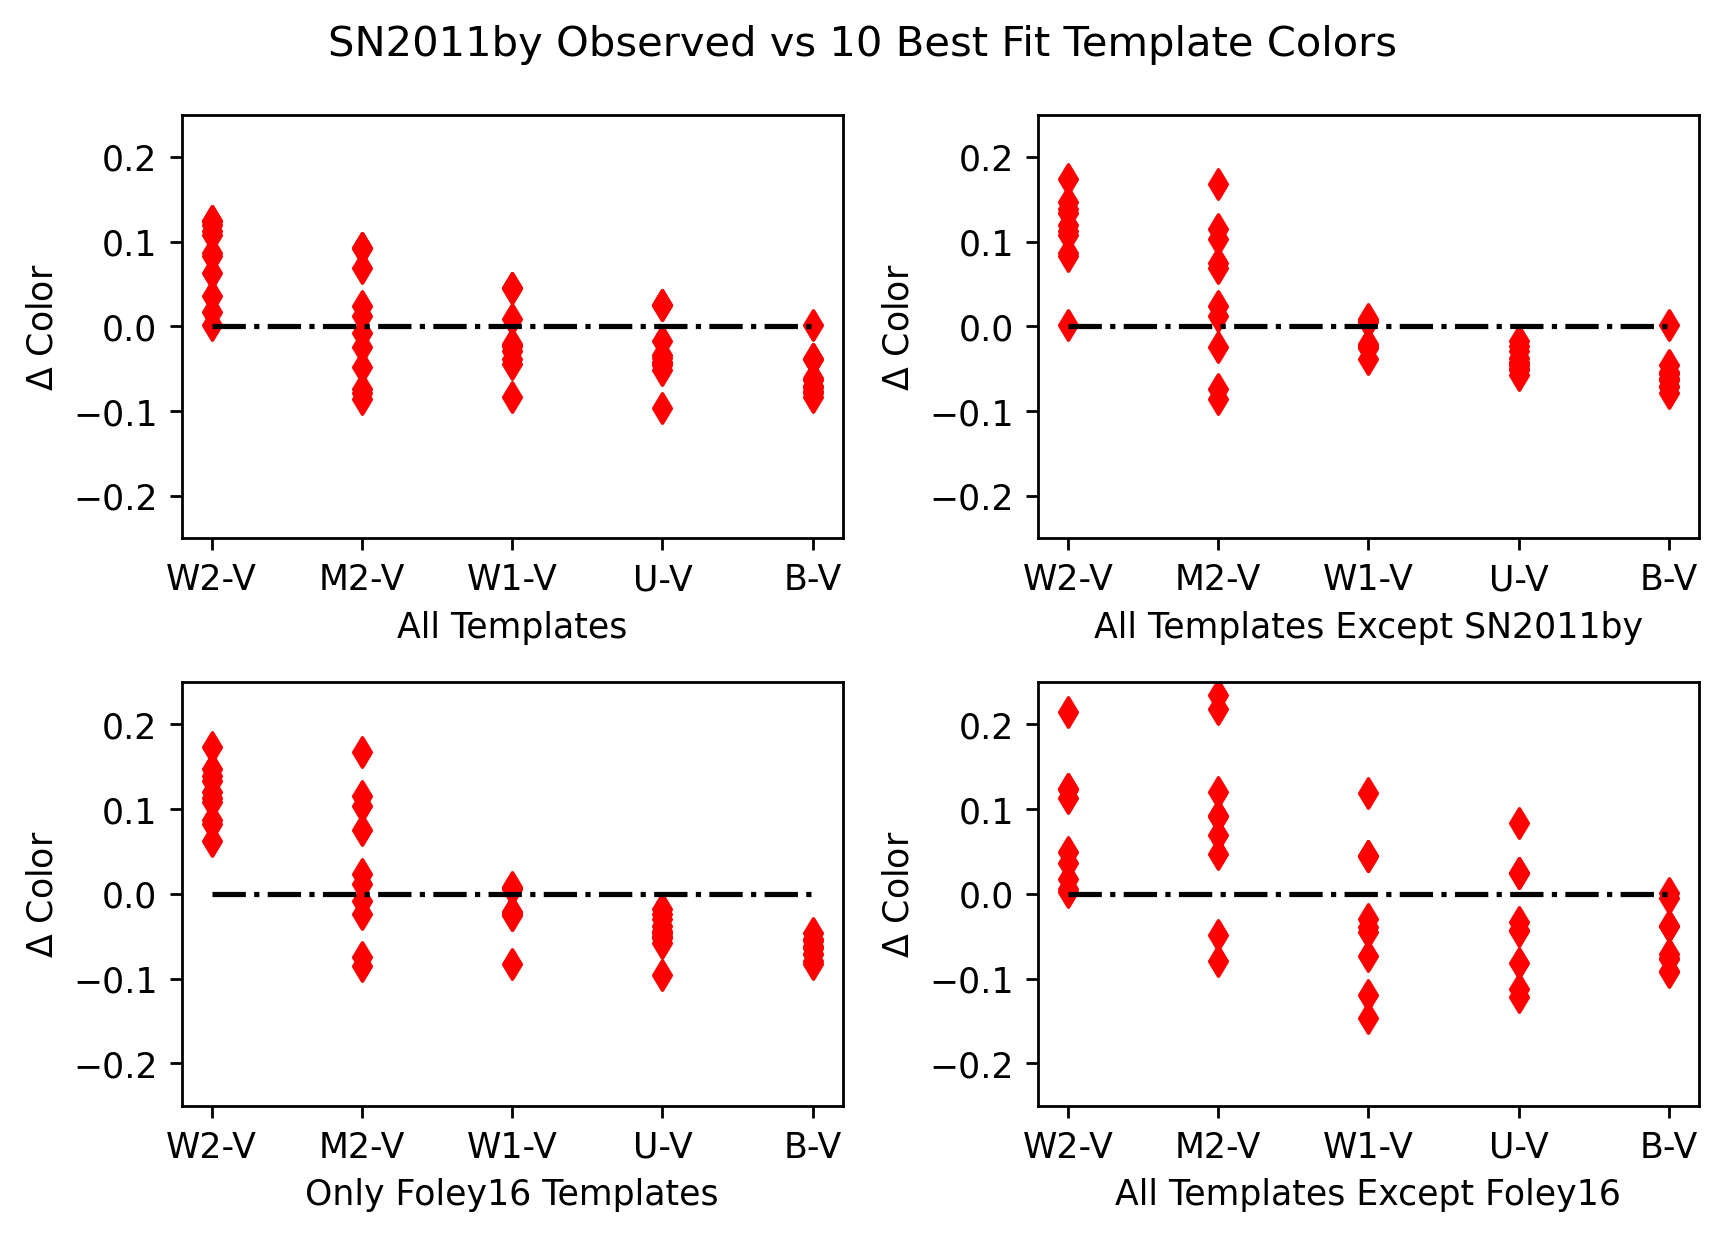

In [3]:
def kfun1(wave,flux):
    f_b = FilterVec[0].get_flux(wave,flux)
    f_b = -2.5*np.log10(f_b) - FilterVec[0].Vega_zero_mag

    f_u = FilterVec[1].get_flux(wave,flux)
    f_u = -2.5*np.log10(f_u) - FilterVec[1].Vega_zero_mag

    f_v = FilterVec[2].get_flux(wave,flux)
    f_v = -2.5*np.log10(f_v) - FilterVec[2].Vega_zero_mag

    f_m2 = FilterVec[3].get_flux(wave,flux)
    f_m2 = -2.5*np.log10(f_m2) - FilterVec[3].Vega_zero_mag

    f_w1 = FilterVec[4].get_flux(wave,flux)
    f_w1 = -2.5*np.log10(f_w1) - FilterVec[4].Vega_zero_mag

    f_w2 = FilterVec[5].get_flux(wave,flux)
    f_w2 = -2.5*np.log10(f_w2) - FilterVec[5].Vega_zero_mag

    return [f_w2,f_m2,f_w1,f_u,f_b]-f_v

plt.figure(1,figsize=(7,5),dpi=250)
targ = 'SN2011by'
df = pd.read_csv('SNPY_Sample_Decline_color2.csv')
tp = df.loc[(df.sname == targ)]
tp = tp.reset_index(drop=True)
obs_col = [tp.w2mag[0], tp.m2mag[0], tp.w1mag[0], tp.umag[0], tp.bmag[0]] - tp.vmag[0]
sys.stdout = open('dummy.txt', 'w')
cols = ['W2-V','M2-V','W1-V','U-V','B-V']
plt.title('$\Delta$ Color Between SN2011by and 10 Best Fit Templates')

plt.subplot(221)
cf = pd.read_csv('outputs/'+targ+'/output_color2.csv')
cols = ['W2-V','M2-V','W1-V','U-V','B-V']
for i in range(len(cf)):
    #print(cf.Template[i])
    Tdata = pd.read_csv('outputs/models/'+cf.Template[i])
    SpectrumFlux = np.asarray(Tdata.flux)/max(Tdata.flux)
    SlambdaWave = np.asarray(Tdata.wavelength)*(1+tp.z[0])
    #print(SlambdaWave)
    tcol = kfun1(SlambdaWave,SpectrumFlux)
    #print(tcol)
    plt.scatter(cols,obs_col-tcol,color='red',marker='d')
#plt.scatter(cols,obs_col,color='black')
plt.ylabel('$\Delta$ Color')
plt.xlabel('All Templates')
plt.ylim(-0.25,0.25)
plt.hlines(0.0,'W2-V','B-V',color='black',linestyle='-.')



plt.subplot(222)
cf = pd.read_csv('outputs/'+targ+'/output_noby.csv')
cols = ['W2-V','M2-V','W1-V','U-V','B-V']
for i in range(len(cf)):
    #print(cf.Template[i])
    Tdata = pd.read_csv('outputs/models/'+cf.Template[i])
    SpectrumFlux = np.asarray(Tdata.flux)/max(Tdata.flux)
    SlambdaWave = np.asarray(Tdata.wavelength)*(1+tp.z[0])
    #print(SlambdaWave)
    tcol = kfun1(SlambdaWave,SpectrumFlux)
    #print(tcol)
    plt.scatter(cols,obs_col-tcol,color='red',marker='d')
#plt.scatter(cols,obs_col,color='black')
plt.ylabel('$\Delta$ Color')
plt.xlabel('All Templates Except SN2011by')
plt.ylim(-0.25,0.25)
plt.hlines(0.0,'W2-V','B-V',color='black',linestyle='-.')


plt.subplot(223)
cf = pd.read_csv('outputs/'+targ+'/output_foley.csv')
cols = ['W2-V','M2-V','W1-V','U-V','B-V']
for i in range(len(cf)):
    #print(cf.Template[i])
    Tdata = pd.read_csv('outputs/models/'+cf.Template[i])
    SpectrumFlux = np.asarray(Tdata.flux)/max(Tdata.flux)
    SlambdaWave = np.asarray(Tdata.wavelength)*(1+tp.z[0])
    #print(SlambdaWave)
    tcol = kfun1(SlambdaWave,SpectrumFlux)
    #print(tcol)
    plt.scatter(cols,obs_col-tcol,color='red',marker='d')
#plt.scatter(cols,obs_col,color='black')
plt.ylabel('$\Delta$ Color')
plt.xlabel('Only Foley16 Templates')
plt.ylim(-0.25,0.25)
plt.hlines(0.0,'W2-V','B-V',color='black',linestyle='-.')

plt.subplot(224)
cf = pd.read_csv('outputs/'+targ+'/output_obstemp2.csv')
cols = ['W2-V','M2-V','W1-V','U-V','B-V']
for i in range(len(cf)):
    #print(cf.Template[i])
    Tdata = pd.read_csv('outputs/models/'+cf.Template[i])
    SpectrumFlux = np.asarray(Tdata.flux)/max(Tdata.flux)
    SlambdaWave = np.asarray(Tdata.wavelength)*(1+tp.z[0])
    #print(SlambdaWave)
    tcol = kfun1(SlambdaWave,SpectrumFlux)
    #print(tcol)
    plt.scatter(cols,obs_col-tcol,color='red',marker='d')
#plt.scatter(cols,obs_col,color='black')
plt.ylabel('$\Delta$ Color')
plt.xlabel('All Templates Except Foley16')
plt.ylim(-0.25,0.25)
plt.hlines(0.0,'W2-V','B-V',color='black',linestyle='-.')

plt.suptitle('SN2011by Observed vs 10 Best Fit Template Colors')
plt.tight_layout()
plt.savefig('outputs_color/all_sn2011by.png',facecolor='white')
#plt.show()


In [4]:
df = pd.read_csv('SNPY_Sample_Decline_color2.csv')
cbv1, cbv2, cbv3, cbv4 = [],[],[],[]
cwv1, cwv2, cwv3, cwv4 = [],[],[],[]
erbv, erwv = [],[]
dmz,zed = [], []
cw2v, cmv, cuv = [],[],[]
erw2v, ermv, eruv = [],[],[]
cnam = []
for i in range(len(df)):
    tp = df.iloc[i]
    targ = tp.sname
    dmz.append(tp.dm)
    zed.append(tp.z)
    cnam.append(targ)
    cf = pd.read_csv('outputs/'+targ+'/output_color2.csv')

    V_obs, B_obs, W1_obs = tp.vmag, tp.bmag, tp.w1mag
    cbv1.append(tp.bmag - tp.vmag)
    cwv1.append(tp.w1mag - tp.vmag)
    
    V_MW2 = V_obs - np.mean(cf.V_MW)
    B_MW2 = B_obs - np.mean(cf.B_MW)
    W1_MW2 = W1_obs - np.mean(cf.W1_MW)
    cbv2.append(B_MW2-V_MW2)
    cwv2.append(W1_MW2-V_MW2)
    
    V_K = V_MW2 - np.mean(cf.V_Z)
    B_K = B_MW2 - np.mean(cf.B_Z)
    W1_K = W1_MW2 - np.mean(cf.W1_Z)
    cbv3.append(B_K-V_K)
    cwv3.append(W1_K-V_K)
    
    V_HOST2 = V_K - np.mean(cf.V_HOST)
    B_HOST2 = B_K - np.mean(cf.B_HOST)
    W1_HOST2 = W1_K - np.mean(cf.W1_HOST)
    cbv4.append(B_HOST2-V_HOST2)
    cwv4.append(W1_HOST2-V_HOST2)
    

    UT = tp.umag-np.mean(cf.U_TOT)
    M2T = tp.m2mag-np.mean(cf.M2_TOT)
    W2T = tp.w2mag-np.mean(cf.W2_TOT)
    
    cw2v.append(W2T - V_HOST2)
    cmv.append(M2T - V_HOST2)
    cuv.append(UT - V_HOST2)
    erbv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.B_TOT)**2))
    erwv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.W1_TOT)**2))
    erw2v.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.W2_TOT)**2))
    ermv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.M2_TOT)**2))
    eruv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.U_TOT)**2))
    
    
    
    
df = pd.read_csv('SNPY_Sample_Decline.csv')
xcbv1, xcbv2, xcbv3, xcbv4 = [],[],[],[]
xcwv1, xcwv2, xcwv3, xcwv4 = [],[],[],[]
xerbv, xerwv = [],[]
xdmz,xzed = [], []
xcw2v, xcmv, xcuv = [],[],[]
xerw2v, xermv, xeruv = [],[],[]
xcnam = []
for i in range(len(df)):
    tp = df.iloc[i]
    targ = tp.sname
    xdmz.append(tp.dm)
    xzed.append(tp.z)
    xcnam.append(targ)
    cf = pd.read_csv('outputs/'+targ+'/output.csv')

    V_obs, B_obs, W1_obs = tp.vmag, tp.bmag, tp.w1mag
    xcbv1.append(tp.bmag - tp.vmag)
    xcwv1.append(tp.w1mag - tp.vmag)
    
    V_MW2 = V_obs - np.mean(cf.V_MW)
    B_MW2 = B_obs - np.mean(cf.B_MW)
    W1_MW2 = W1_obs - np.mean(cf.W1_MW)
    xcbv2.append(B_MW2-V_MW2)
    xcwv2.append(W1_MW2-V_MW2)
    
    V_K = V_MW2 - np.mean(cf.V_Z)
    B_K = B_MW2 - np.mean(cf.B_Z)
    W1_K = W1_MW2 - np.mean(cf.W1_Z)
    xcbv3.append(B_K-V_K)
    xcwv3.append(W1_K-V_K)
    
    V_HOST2 = V_K - np.mean(cf.V_HOST)
    B_HOST2 = B_K - np.mean(cf.B_HOST)
    W1_HOST2 = W1_K - np.mean(cf.W1_HOST)
    xcbv4.append(B_HOST2-V_HOST2)
    xcwv4.append(W1_HOST2-V_HOST2)
    

    UT = tp.umag-np.mean(cf.U_TOT)
    M2T = tp.m2mag-np.mean(cf.M2_TOT)
    W2T = tp.w2mag-np.mean(cf.W2_TOT)
    
    xcw2v.append(W2T - V_HOST2)
    xcmv.append(M2T - V_HOST2)
    xcuv.append(UT - V_HOST2)
    xerbv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.B_TOT)**2))
    xerwv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.W1_TOT)**2))
    xerw2v.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.W2_TOT)**2))
    xermv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.M2_TOT)**2))
    xeruv.append(np.sqrt(np.std(cf.V_TOT)**2 + np.std(cf.U_TOT)**2))

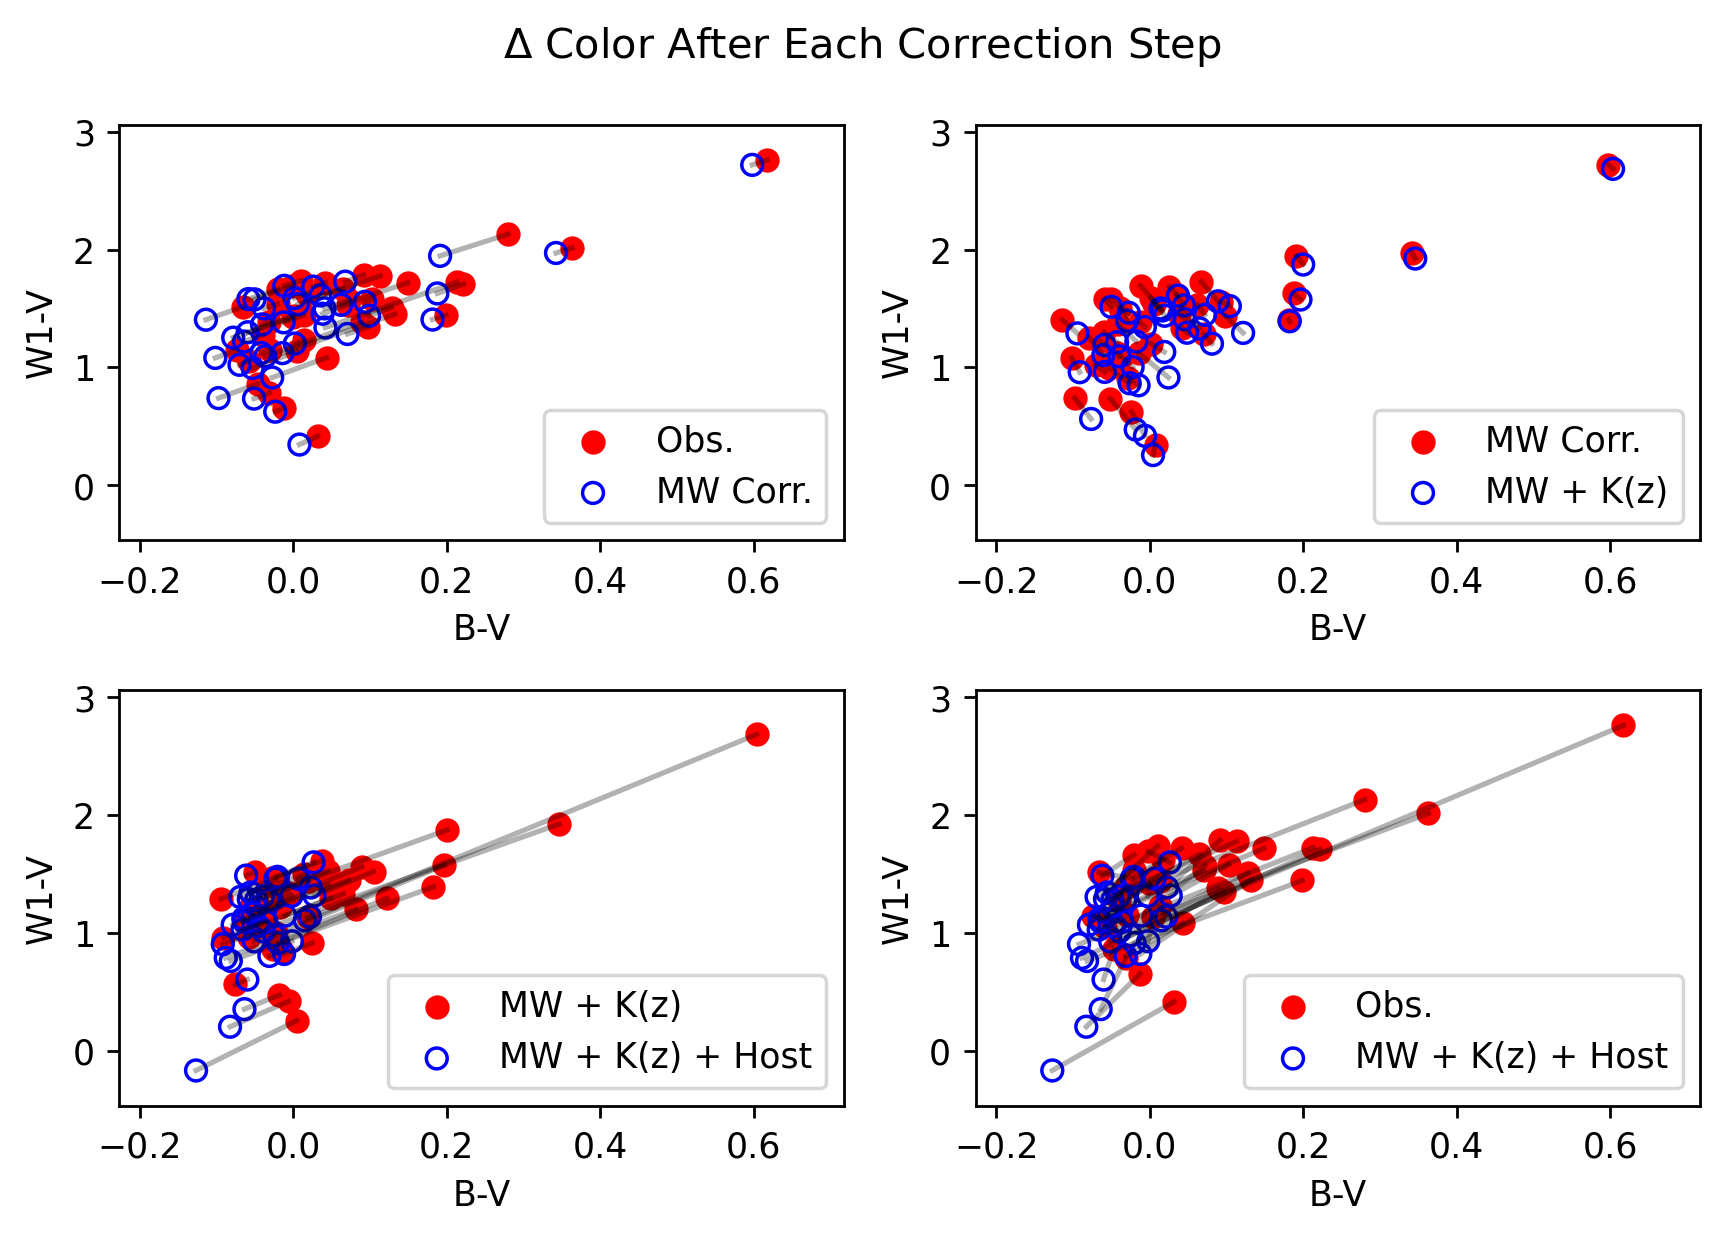

In [5]:
plt.figure(1,figsize=(7,5),dpi=250)
plt.suptitle('$\Delta$ Color After Each Correction Step')
lowx = min(cbv4) -0.1
hix = max(cbv1) +0.1
lowy = min(cwv4)-0.3
hiy = max(cwv1)+0.3

plt.subplot(221)
plt.scatter(cbv1, cwv1,color='red',label='Obs.')
plt.scatter(cbv2, cwv2,edgecolors='blue',label='MW Corr.',facecolors='none')
for i in range(len(cbv1)):
    plt.plot([cbv1[i],cbv2[i]],[cwv1[i],cwv2[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(222)
plt.scatter(cbv2, cwv2,color='red',label='MW Corr.')
plt.scatter(cbv3, cwv3,edgecolors='blue',label='MW + K(z)',facecolors='none')
for i in range(len(cbv1)):
    plt.plot([cbv2[i],cbv3[i]],[cwv2[i],cwv3[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(223)
plt.scatter(cbv3, cwv3,color='red',label='MW + K(z)')
plt.scatter(cbv4, cwv4,edgecolors='blue',label='MW + K(z) + Host',facecolors='none')
for i in range(len(cbv1)):
    plt.plot([cbv3[i],cbv4[i]],[cwv3[i],cwv4[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(224)
plt.scatter(cbv1, cwv1,color='red',label='Obs.')
plt.scatter(cbv4, cwv4,edgecolors='blue',label='MW + K(z) + Host',facecolors='none')
for i in range(len(cbv1)):
    plt.plot([cbv1[i],cbv4[i]],[cwv1[i],cwv4[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)
  

plt.tight_layout()
plt.savefig('outputs_color/all_stepwise.png',facecolor='white')
#plt.show()

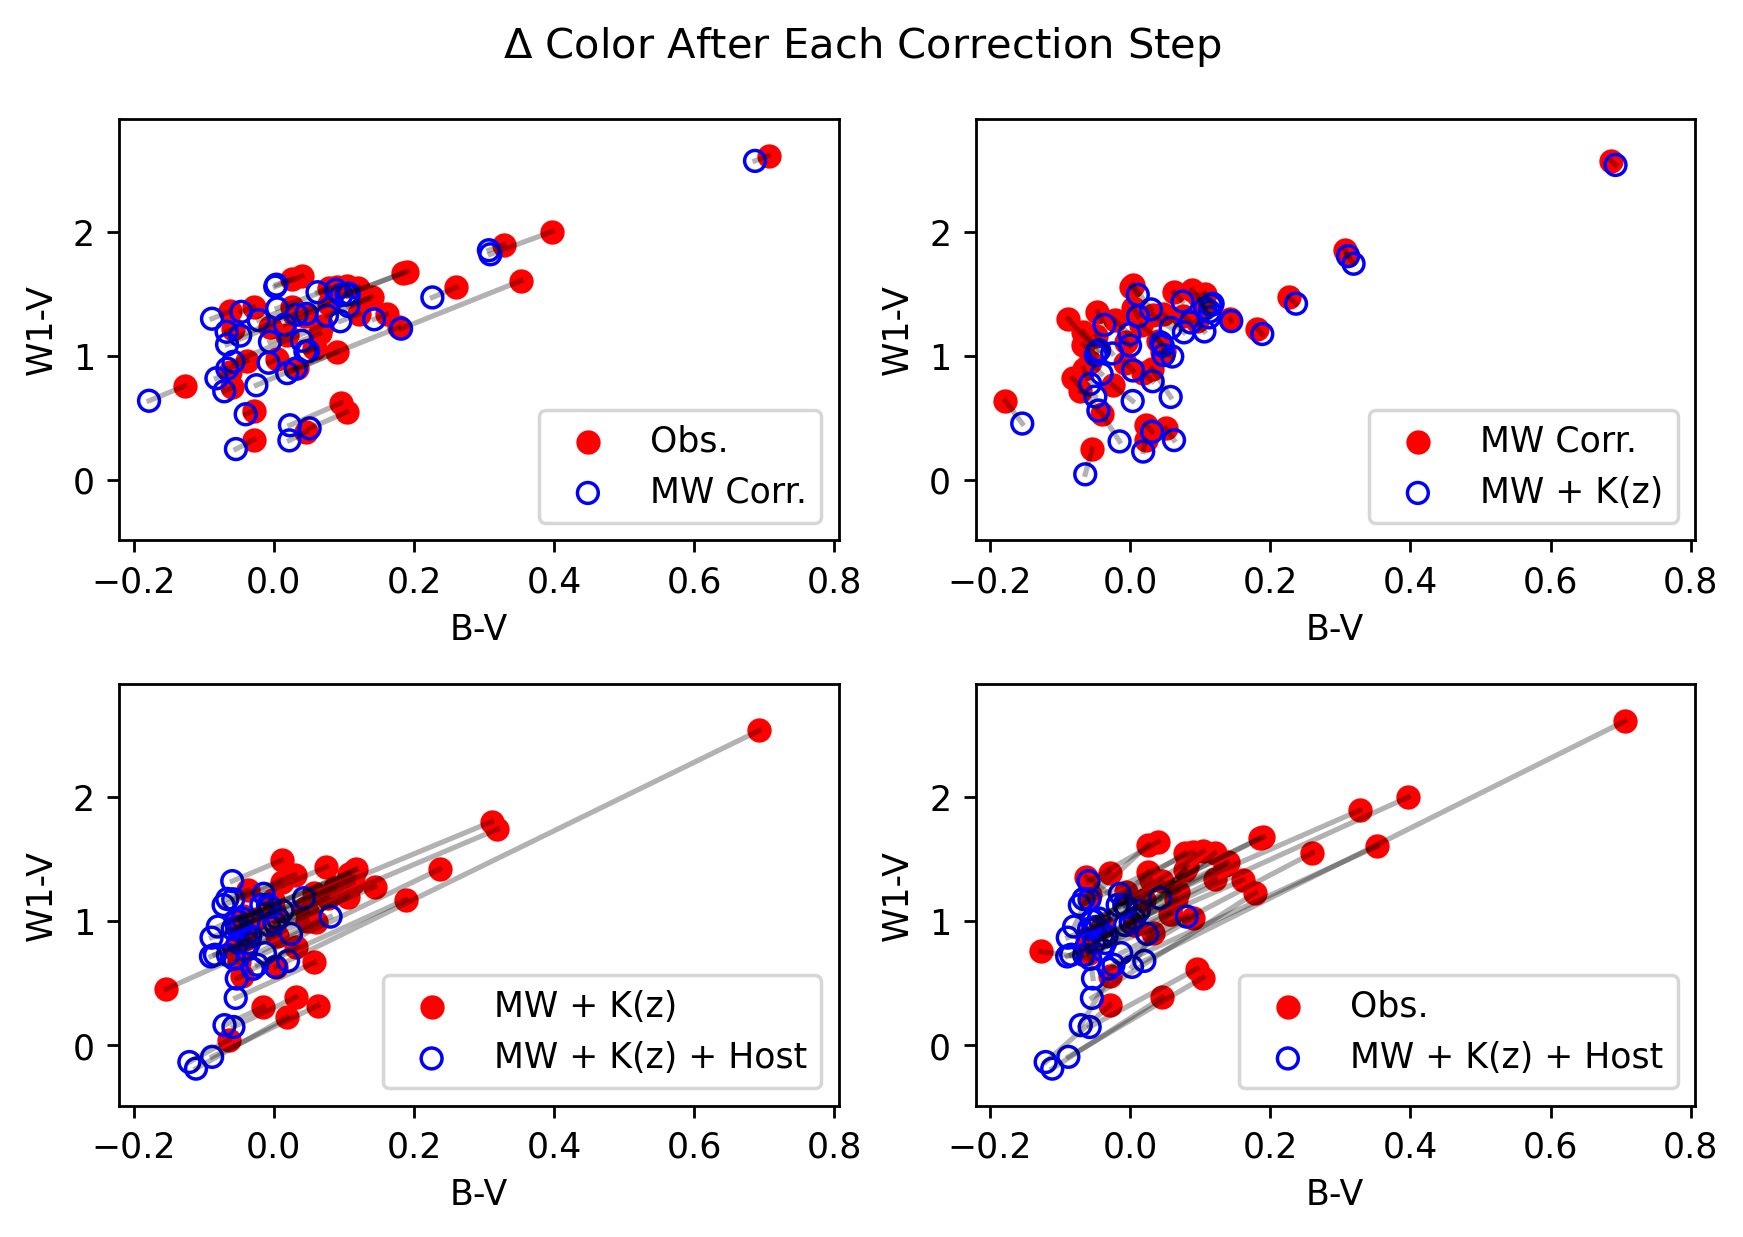

In [6]:
plt.figure(1,figsize=(7,5),dpi=250)
plt.suptitle('$\Delta$ Color After Each Correction Step')
lowx = min(xcbv4) -0.1
hix = max(xcbv1) +0.1
lowy = min(xcwv4)-0.3
hiy = max(xcwv1)+0.3

plt.subplot(221)
plt.scatter(xcbv1, xcwv1,color='red',label='Obs.')
plt.scatter(xcbv2, xcwv2,edgecolors='blue',label='MW Corr.',facecolors='none')
for i in range(len(xcbv1)):
    plt.plot([xcbv1[i],xcbv2[i]],[xcwv1[i],xcwv2[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(222)
plt.scatter(xcbv2, xcwv2,color='red',label='MW Corr.')
plt.scatter(xcbv3, xcwv3,edgecolors='blue',label='MW + K(z)',facecolors='none')
for i in range(len(xcbv1)):
    plt.plot([xcbv2[i],xcbv3[i]],[xcwv2[i],xcwv3[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(223)
plt.scatter(xcbv3, xcwv3,color='red',label='MW + K(z)')
plt.scatter(xcbv4, xcwv4,edgecolors='blue',label='MW + K(z) + Host',facecolors='none')
for i in range(len(xcbv1)):
    plt.plot([xcbv3[i],xcbv4[i]],[xcwv3[i],xcwv4[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)

plt.subplot(224)
plt.scatter(xcbv1, xcwv1,color='red',label='Obs.')
plt.scatter(xcbv4, xcwv4,edgecolors='blue',label='MW + K(z) + Host',facecolors='none')
for i in range(len(xcbv1)):
    plt.plot([xcbv1[i],xcbv4[i]],[xcwv1[i],xcwv4[i]],color='black',alpha=0.3)
plt.legend(loc='lower right')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)
  

plt.tight_layout()
plt.savefig('outputs/all_stepwise.png',facecolor='white')
#plt.show()

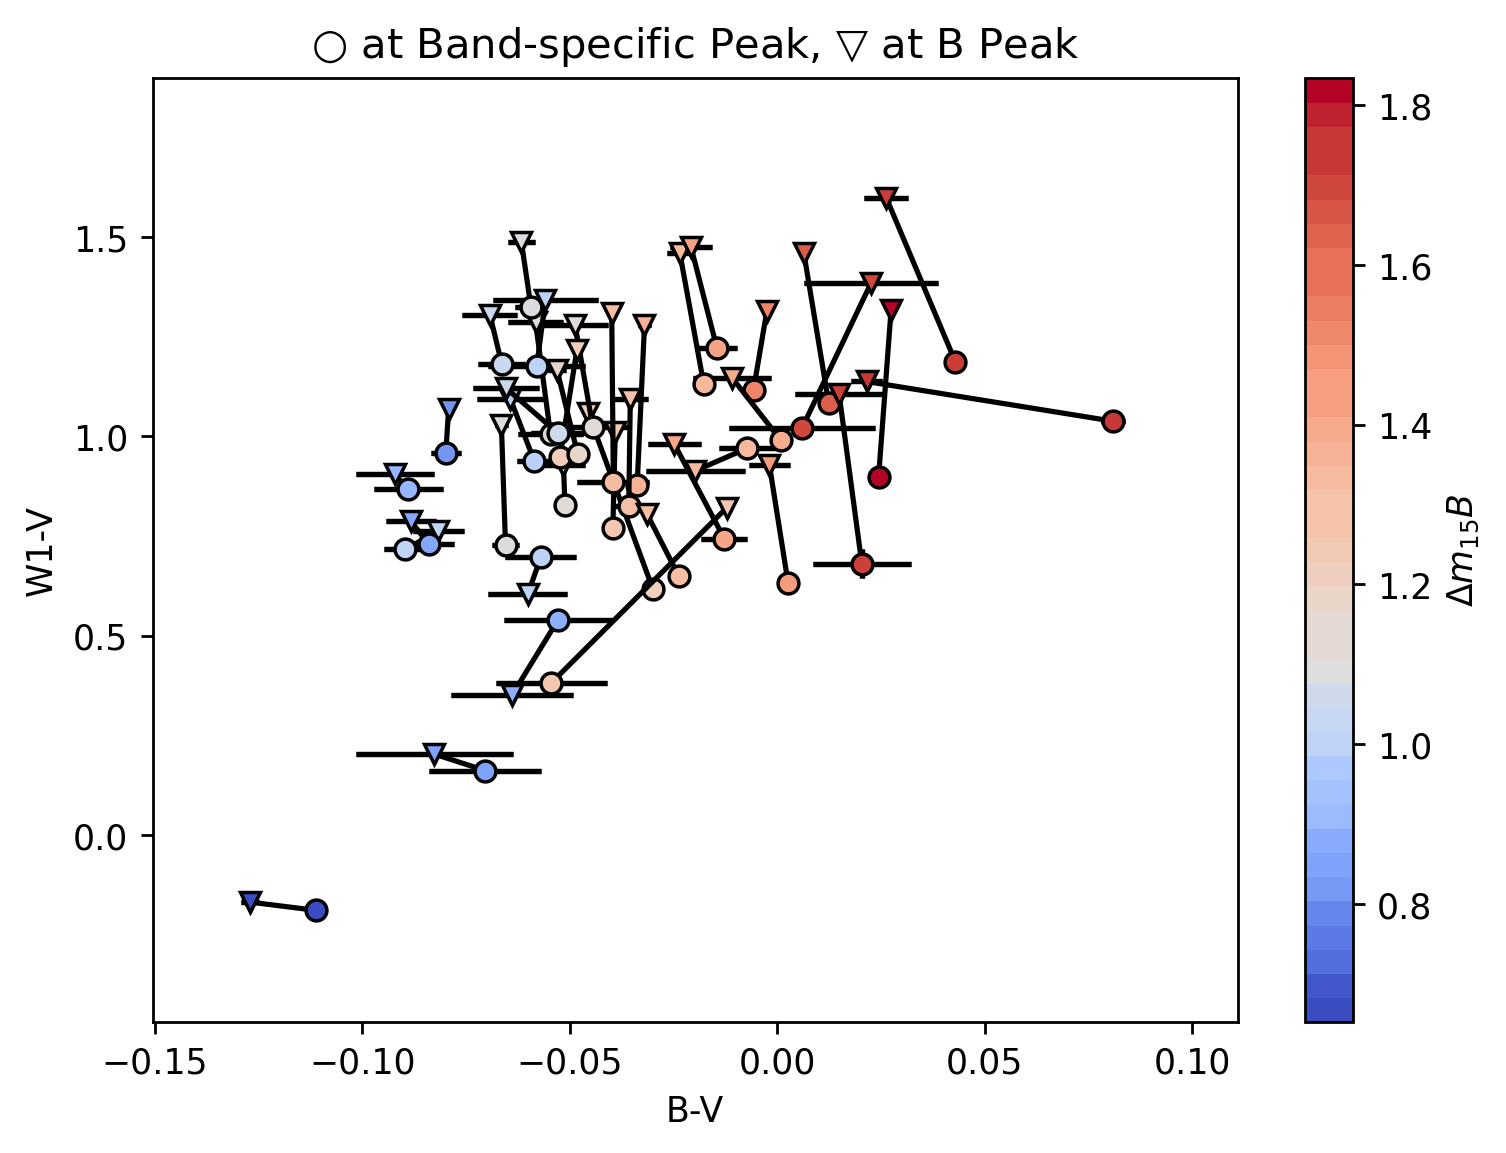

In [7]:
plt.figure(1,figsize=(7,5),dpi=250)

divnorm = colors.TwoSlopeNorm(vmin=min(dmz), vcenter=1.1, vmax=max(dmz))
mycmap = plt.get_cmap('coolwarm')(divnorm(dmz))
smap = plt.get_cmap('coolwarm',len(dmz))

lowx = min(xcbv4) -0.03
hix = max(xcbv4) +0.03
lowy = min(cwv4)-0.3
hiy = max(cwv4)+0.3


for y in range(len(dmz)):
    for x in range(len(xdmz)):
        if cnam[y] == xcnam[x]:
            plt.errorbar([xcbv4[x],cbv4[y]],[xcwv4[x],cwv4[y]],xerr=[xerbv[x],erbv[y]],yerr=[xerwv[x],erwv[y]],
                         ecolor='black',marker=',',mfc=mycmap[y],mec='black',color='black')
            plt.errorbar(xcbv4[x],xcwv4[x],xerr=xerbv[x],yerr=xerwv[x],
                         ecolor='black',marker='o',mfc=mycmap[y],mec='black')
            plt.errorbar(cbv4[y],cwv4[y],xerr=erbv[y],yerr=erwv[y],
                         ecolor='black',marker='v',mfc=mycmap[y],mec='black')
                
sm1 = plt.cm.ScalarMappable(cmap=smap, norm=divnorm)
plt.colorbar(sm1,label='$\Delta m_{15}B$')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.title('$\\bigcirc$ at Band-specific Peak, $\\bigtriangledown$ at B Peak')


plt.savefig('outputs_color/all_colorcolor_delta.png',facecolor='white')
#plt.tight_layout()
#plt.show()

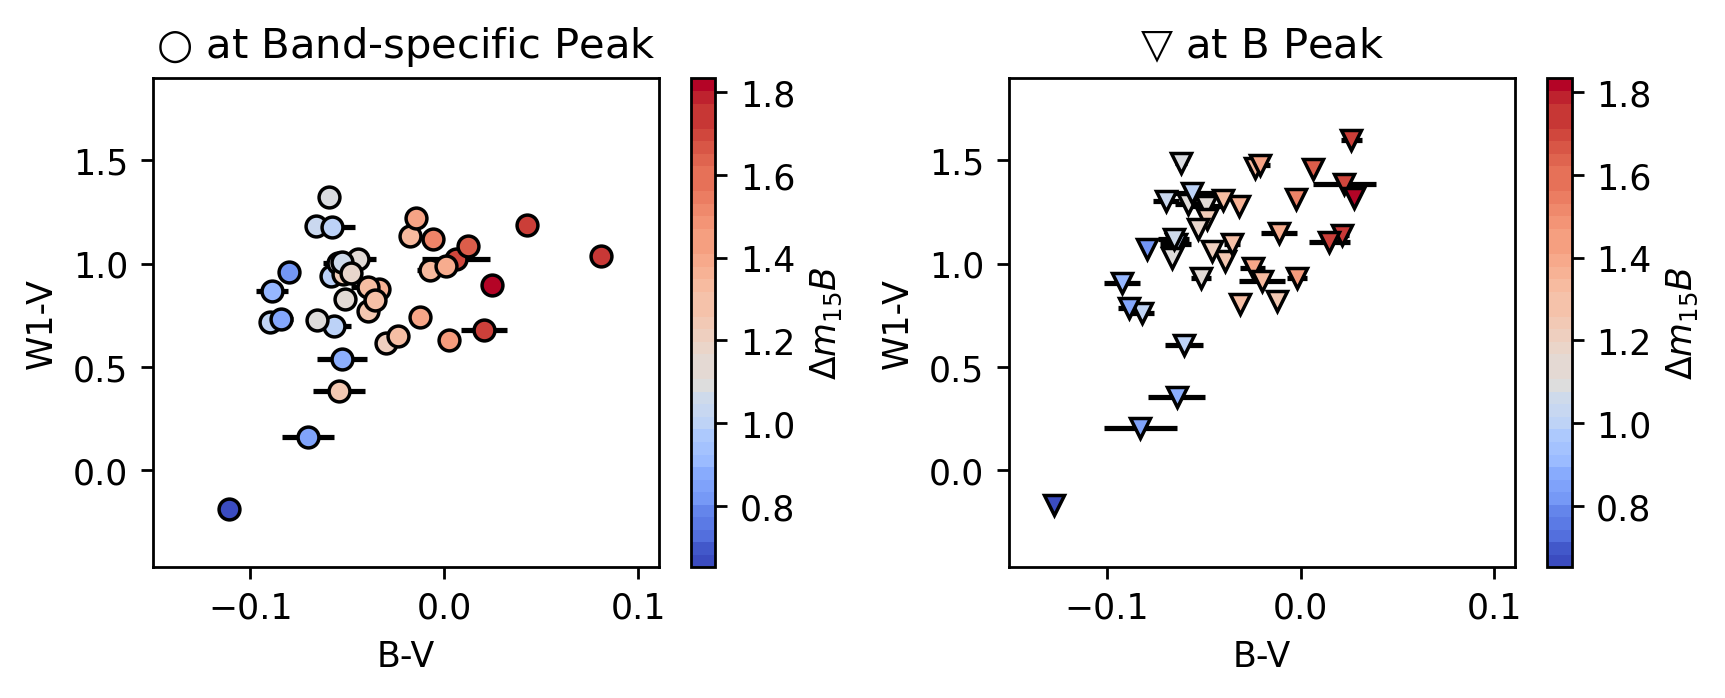

In [8]:
plt.figure(1,figsize=(7,5),dpi=250)

divnorm = colors.TwoSlopeNorm(vmin=min(dmz), vcenter=1.1, vmax=max(dmz))
mycmap = plt.get_cmap('coolwarm')(divnorm(dmz))
smap = plt.get_cmap('coolwarm',len(dmz))

lowx = min(xcbv4) -0.03
hix = max(xcbv4) +0.03
lowy = min(cwv4)-0.3
hiy = max(cwv4)+0.3


plt.subplot(221)
for y in range(len(dmz)):
    for x in range(len(xdmz)):
        if cnam[y] == xcnam[x]:
            #plt.errorbar([xcbv4[x],cbv4[y]],[xcwv4[x],cwv4[y]],xerr=[xerbv[x],erbv[y]],yerr=[xerwv[x],erwv[y]],
                         #ecolor='black',marker=',',mfc=mycmap[y],mec='black',color='black')
            plt.errorbar(xcbv4[x],xcwv4[x],xerr=xerbv[x],yerr=xerwv[x],
                         ecolor='black',marker='o',mfc=mycmap[y],mec='black')
            #plt.errorbar(cbv4[y],cwv4[y],xerr=erbv[y],yerr=erwv[y],
                         #ecolor='black',marker='v',mfc=mycmap[y],mec='black')
                
sm1 = plt.cm.ScalarMappable(cmap=smap, norm=divnorm)
plt.colorbar(sm1,label='$\Delta m_{15}B$')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.title('$\\bigcirc$ at Band-specific Peak')

plt.subplot(222)
for y in range(len(dmz)):
    for x in range(len(xdmz)):
        if cnam[y] == xcnam[x]:
            #plt.errorbar([xcbv4[x],cbv4[y]],[xcwv4[x],cwv4[y]],xerr=[xerbv[x],erbv[y]],yerr=[xerwv[x],erwv[y]],
                         #ecolor='black',marker=',',mfc=mycmap[y],mec='black',color='black')
            #plt.errorbar(xcbv4[x],xcwv4[x],xerr=xerbv[x],yerr=xerwv[x],
                         #ecolor='black',marker='o',mfc=mycmap[y],mec='black')
            plt.errorbar(cbv4[y],cwv4[y],xerr=erbv[y],yerr=erwv[y],
                         ecolor='black',marker='v',mfc=mycmap[y],mec='black')
                
sm1 = plt.cm.ScalarMappable(cmap=smap, norm=divnorm)
plt.colorbar(sm1,label='$\Delta m_{15}B$')
plt.xlim(lowx,hix)
plt.ylim(lowy,hiy)
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.title('$\\bigtriangledown$ at B Peak')

plt.tight_layout()
plt.savefig('outputs_color/all_colorcolor.png',facecolor='white')
#plt.show()

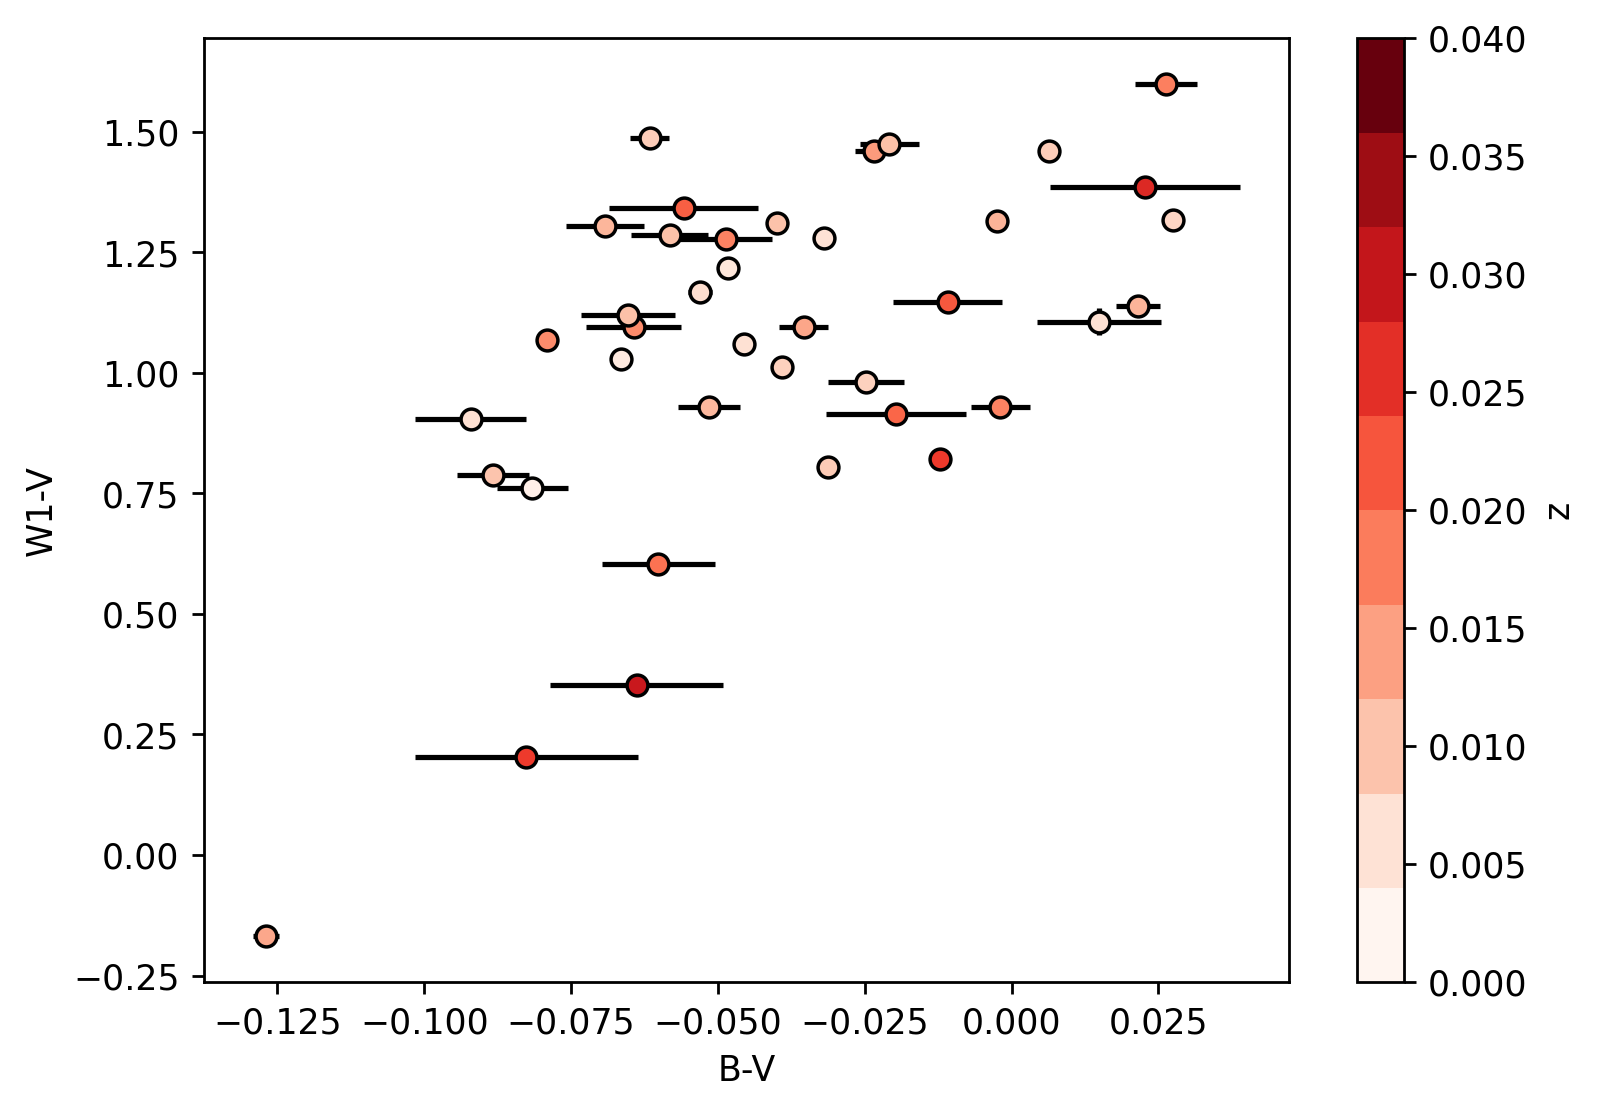

In [9]:
plt.figure(1,figsize=(7,5),dpi=250)

divnorm2 = colors.TwoSlopeNorm(vmin=0.0, vcenter=0.02, vmax=0.04)
mycmap2 = plt.get_cmap('Reds')(divnorm2(zed))
smap2 = plt.get_cmap('Reds',10)

for y in range(len(zed)):
    plt.errorbar(cbv4[y],cwv4[y],xerr=erbv[y],yerr=erwv[y],ecolor='black',marker='o',mfc=mycmap2[y],mec='black')
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='z')
plt.xlabel('B-V')
plt.ylabel('W1-V')
plt.savefig('outputs_color/all_z.png',facecolor='white')

In [10]:
UT, M2T, W1T, W2T, BT, VT = [],[],[],[],[],[]
EU, EB, EV, EW2, EW1, EM2 = [],[],[],[],[],[]
dmz = []
dmze = []
zed = []
reddy = []
dtargs = []
dismo_n, dismo_e = [], []
df = pd.read_csv('SNPY_Sample_Decline_color2.csv')
sf = pd.read_csv('snbrown_output_20240426.csv', skipinitialspace=True)
sf.columns = sf.columns.str.lstrip()
berry = pd.read_csv('snfits_data/berr.csv')
swift = pd.read_csv('NewSwiftSNweblist.csv')
print(df)
for i in range(len(df)):
    tp = df.iloc[i]
    targ = tp.sname
    
    
    sn_name = tp.sname
    idex= swift.loc[swift.isin([sn_name]).any(axis=1)].index.tolist()
    idex=idex[0]
    Dist_method= swift['Method_best'][idex]
    Dist_mod= swift['Distance_best'][idex]
    Dist_err= float(swift['Distance_err_best'][idex])
    Dist_ref= swift['Refer_best'][idex]

    
    
    if tp.dm > 1.5:
        print(targ)
    elif np.isnan(Dist_mod) == True:
        print(targ)
    else:
        dmz.append(tp.dm)
        zed.append(tp.z)
        cf = pd.read_csv('outputs/'+targ+'/output_color2.csv')
        sp = sf.loc[(sf.snname2 == tp.sname)]
        sp = sp.reset_index(drop=True)
        berk = berry.loc[(berry.SNname == targ)]
        berk = berk.reset_index(drop=True)
        dmze.append(berk.dmstd[0])
        dtargs.append(targ)
        #print(targ)
        #print(sp.u_eMmax)
        UT.append(tp.umag-np.mean(cf.U_TOT))
        M2T.append(tp.m2mag-np.mean(cf.M2_TOT))
        W2T.append(tp.w2mag-np.mean(cf.W2_TOT))
        W1T.append(tp.w1mag-np.mean(cf.W1_TOT))
        BT.append(tp.bmag-np.mean(cf.B_TOT))
        VT.append(tp.vmag-np.mean(cf.V_TOT))
    
        EU.append(np.sqrt( np.std(cf.U_TOT)**2 + sp.U_eMBmax[0]**2))
        EB.append(np.sqrt( np.std(cf.B_TOT)**2 + sp.B_eMmax[0]**2))
        EV.append(np.sqrt( np.std(cf.V_TOT)**2 + sp.V_eBMmax[0]**2))
        EW2.append(np.sqrt( np.std(cf.W2_TOT)**2 + sp.W2_eMBmax[0]**2))
        EW1.append(np.sqrt( np.std(cf.W1_TOT)**2 + sp.W1_eMBmax[0]**2))
        EM2.append(np.sqrt( np.std(cf.M2_TOT)**2 + sp.M2_eMBmax[0]**2))

        dx = (((tp.bmag-np.mean(cf.B_TOT))-(tp.vmag-np.mean(cf.V_TOT))) - (tp.bmag-tp.vmag))**2
        dy = (((tp.w1mag-np.mean(cf.W1_TOT))-(tp.vmag-np.mean(cf.V_TOT))) - (tp.w1mag-tp.vmag))**2
        reddy.append(np.sqrt(dx+dy))
        dismo_n.append(Dist_mod)
        dismo_e.append(Dist_err)
        

        
        if (W1T[-1]- VT[-1]) < 0.0:
            print('Super-C: '+str(targ))
    #reddy.append(np.mean(cf.V_HOST))
    
    
UT = np.asarray(UT) 
VT = np.asarray(VT) 
BT = np.asarray(BT) 
W1T = np.asarray(W1T) 
W2T = np.asarray(W2T) 
M2T = np.asarray(M2T) 

EU = np.asarray(EU)
EB = np.asarray(EB)
EV = np.asarray(EV)
EW2 = np.asarray(EW2)
EM2 = np.asarray(EM2)
EW1 = np.asarray(EW1)
reddy = np.asarray(reddy)
dmze = np.asarray(dmze)
dismo_n = np.asarray(dismo_n)
dismo_e = np.asarray(dismo_e)
print(len(UT))
print(len(df))
# fff = cosmo.luminosity_distance(zed) 
print(dismo_e)
print(dismo_n)
print(zed)

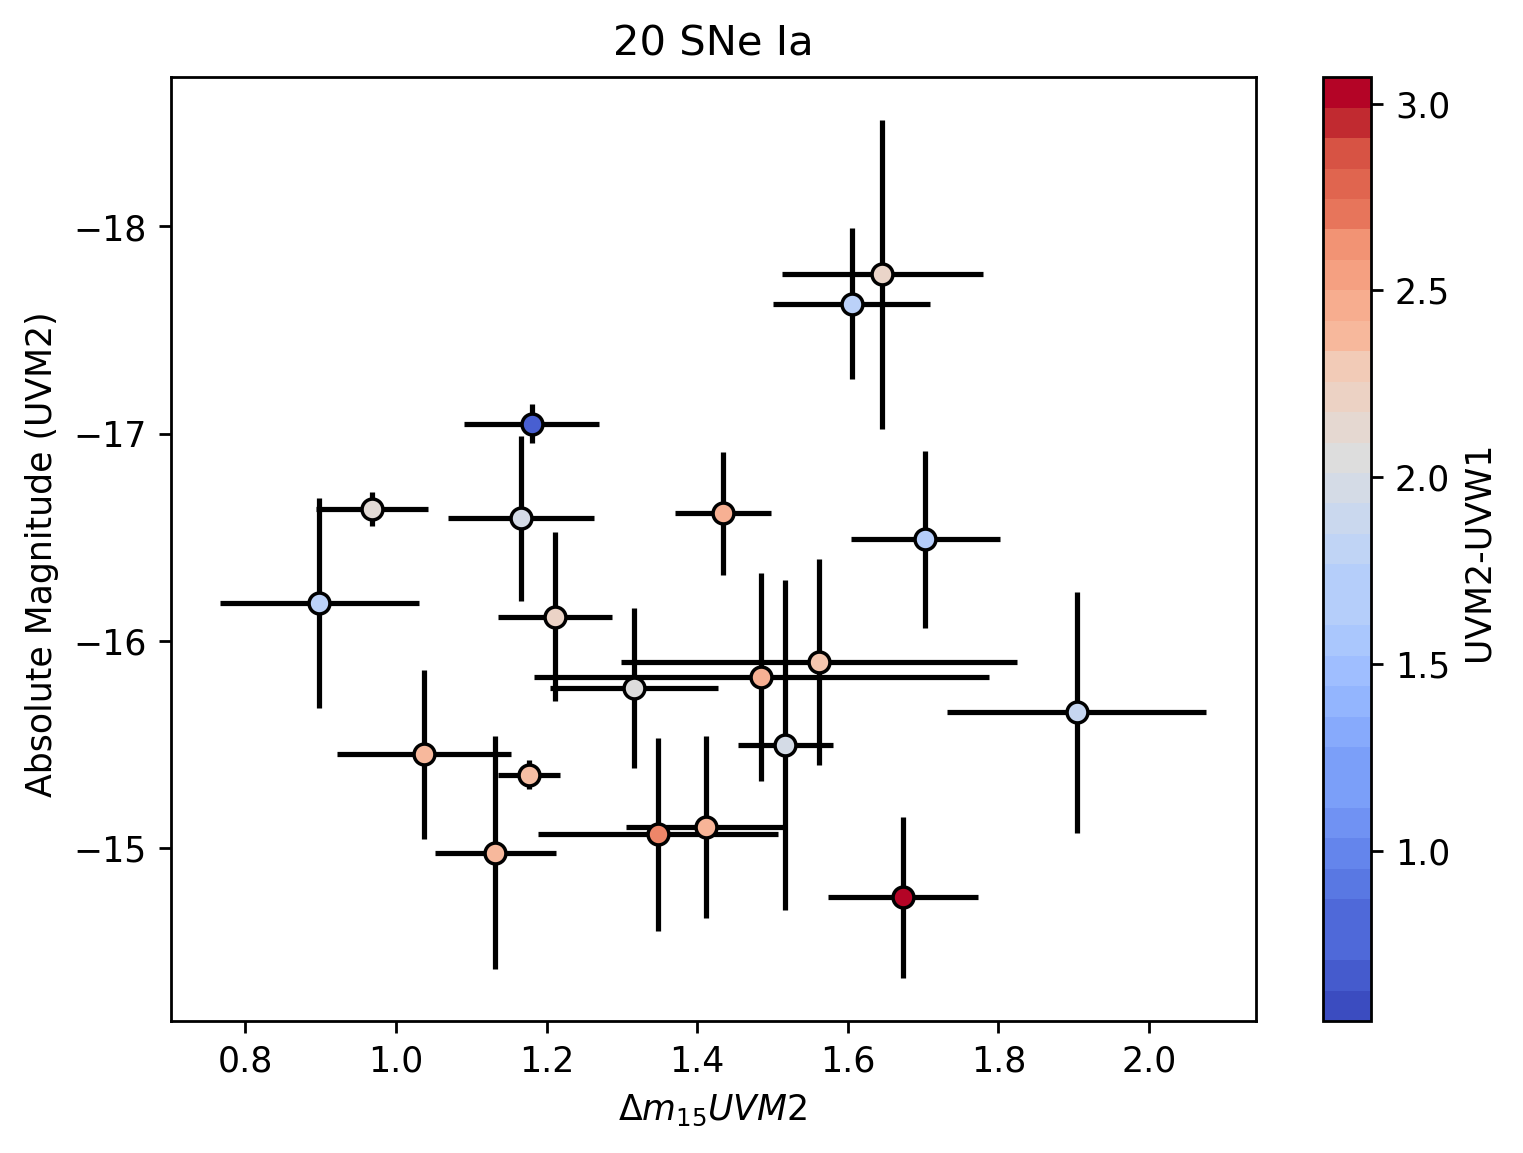

In [11]:
joke = pd.read_csv('snfits_data/m2err.csv')
poke = pd.read_csv('snfits_data/m2data.csv')
dgen, dfen = [],[]
for i in range(len(df)):
    tp = df.iloc[i]
    targ = tp.sname
    if len(poke.loc[(poke.SNname == targ)]) == 0:
#         print(targ)
        dgen.append(0)
        dfen.append(0)
    else:
        merk = poke.loc[(poke.SNname == targ)]
#         print(targ)
#         print(len(merk))
        merk = merk.reset_index(drop=True)
#         print(merk)
        
        jerk = joke.loc[(joke.SNname == targ)]
        jerk = jerk.reset_index(drop=True)
        dgen.append(merk.dM15[0])
        dfen.append(jerk.dmstd[0])

        
        
plt.figure(1,figsize=(7,5),dpi=250)
dx = dgen
dz = M2T-W1T
dy = M2T
dxe = dfen
dye = np.sqrt(EM2**2 + dismo_e**2)

nbt = []
# for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
#     nbt.append(dy[i]-dismo)
dy = dy - dismo_n
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=np.median(dz), vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))   
cnt = 0
for i in range(len(zed)):
    if dx[i] > 0.0:
            plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
            cnt = cnt+1
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='UVM2-UVW1 ')
plt.xlabel('$\Delta m_{15}UVM2$')
plt.ylabel('Absolute Magnitude (UVM2) ')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
plt.gca().invert_yaxis()

plt.title(str(cnt)+' SNe Ia')
plt.savefig('outputs_color/all_uvdecline22.png',facecolor='white')

#plt.show()

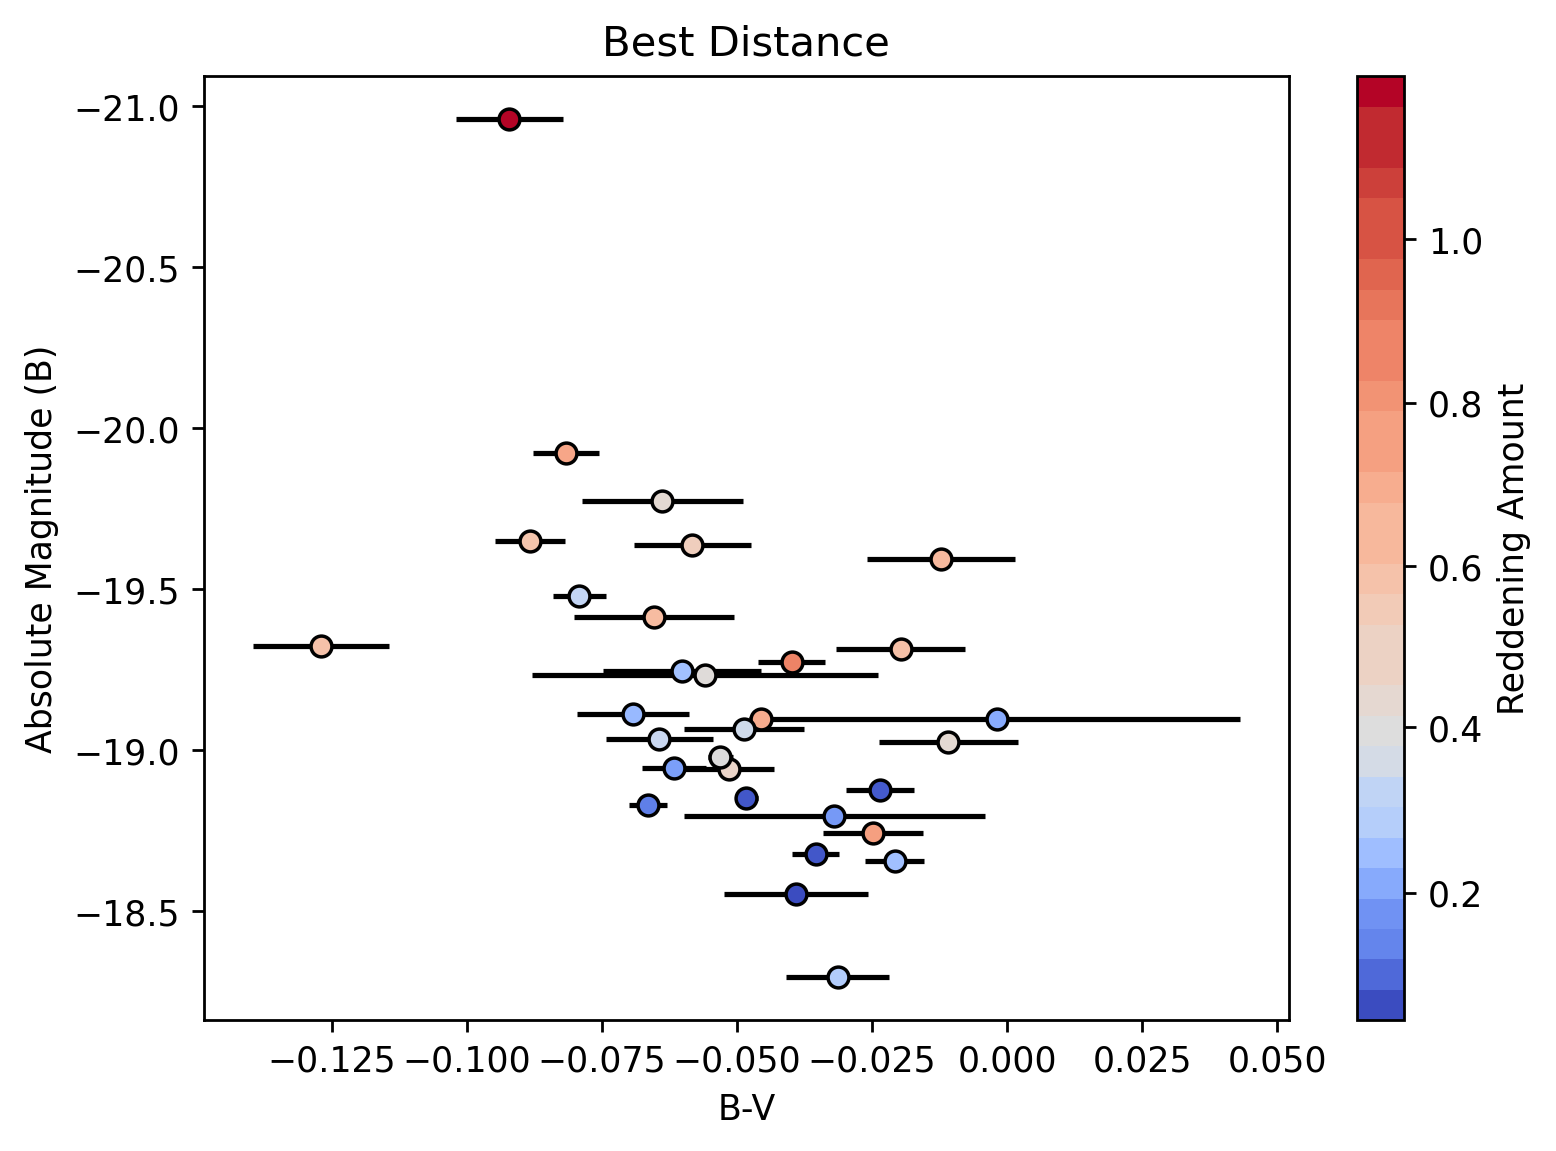

In [12]:
fff = cosmo.luminosity_distance(zed)  

# for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
#     plt.scatter(BT[i]-VT[i], BT[i]-dismo)
# plt.show()
print(fff)
plt.figure(1,figsize=(7,5),dpi=250)
yar = reddy
divnorm2 = colors.TwoSlopeNorm(vmin=min(yar), vcenter=np.median(yar), vmax=max(yar))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(yar))
smap2 = plt.get_cmap('coolwarm',len(yar))

for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    if BT[i]-dismo > -19:
        print(dtargs[i], BT[i]-dismo, dismo, dismo_n[i])
    plt.errorbar(BT[i]-VT[i], BT[i]-dismo_n[i],yerr=EB[i],xerr=np.sqrt(EB[i]**2 + EV[i]**2),
                 ecolor='black',marker='o',mfc=mycmap2[i],mec='black')

sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='Reddening Amount')
plt.xlabel('B-V')
plt.ylabel('Absolute Magnitude (B)')
plt.gca().invert_yaxis()
plt.title('Best Distance')
plt.savefig('outputs_color/B_BV_BestDistance.png',facecolor='white')

In [13]:
# fff = cosmo.luminosity_distance(zed)  

# # for i in range(len(zed)):
# #     par = fff[i].value
# #     dismo = 5*np.log10(par*(10**5))
# #     plt.scatter(BT[i]-VT[i], BT[i]-dismo)
# # plt.show()
# print(fff)
# plt.figure(1,figsize=(7,5),dpi=250)
# yar = reddy
# divnorm2 = colors.TwoSlopeNorm(vmin=min(yar), vcenter=np.median(yar), vmax=max(yar))
# mycmap2 = plt.get_cmap('coolwarm')(divnorm2(yar))
# smap2 = plt.get_cmap('coolwarm',len(yar))

# for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
#     if BT[i]-dismo > -19:
#         print(dtargs[i], BT[i]-dismo, dismo, dismo_n[i])
#     plt.errorbar(BT[i]-VT[i], BT[i]-dismo,yerr=EB[i],xerr=np.sqrt(EB[i]**2 + EV[i]**2),
#                  ecolor='black',marker='o',mfc=mycmap2[i],mec='black')

# sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# plt.colorbar(sm1,label='Reddening Amount')
# plt.xlabel('B-V')
# plt.ylabel('Absolute Magnitude (B)')
# plt.gca().invert_yaxis()
# plt.title('Luminosity Distance')
# plt.savefig('outputs/B_BV_LuminosityDistance.png',facecolor='white')

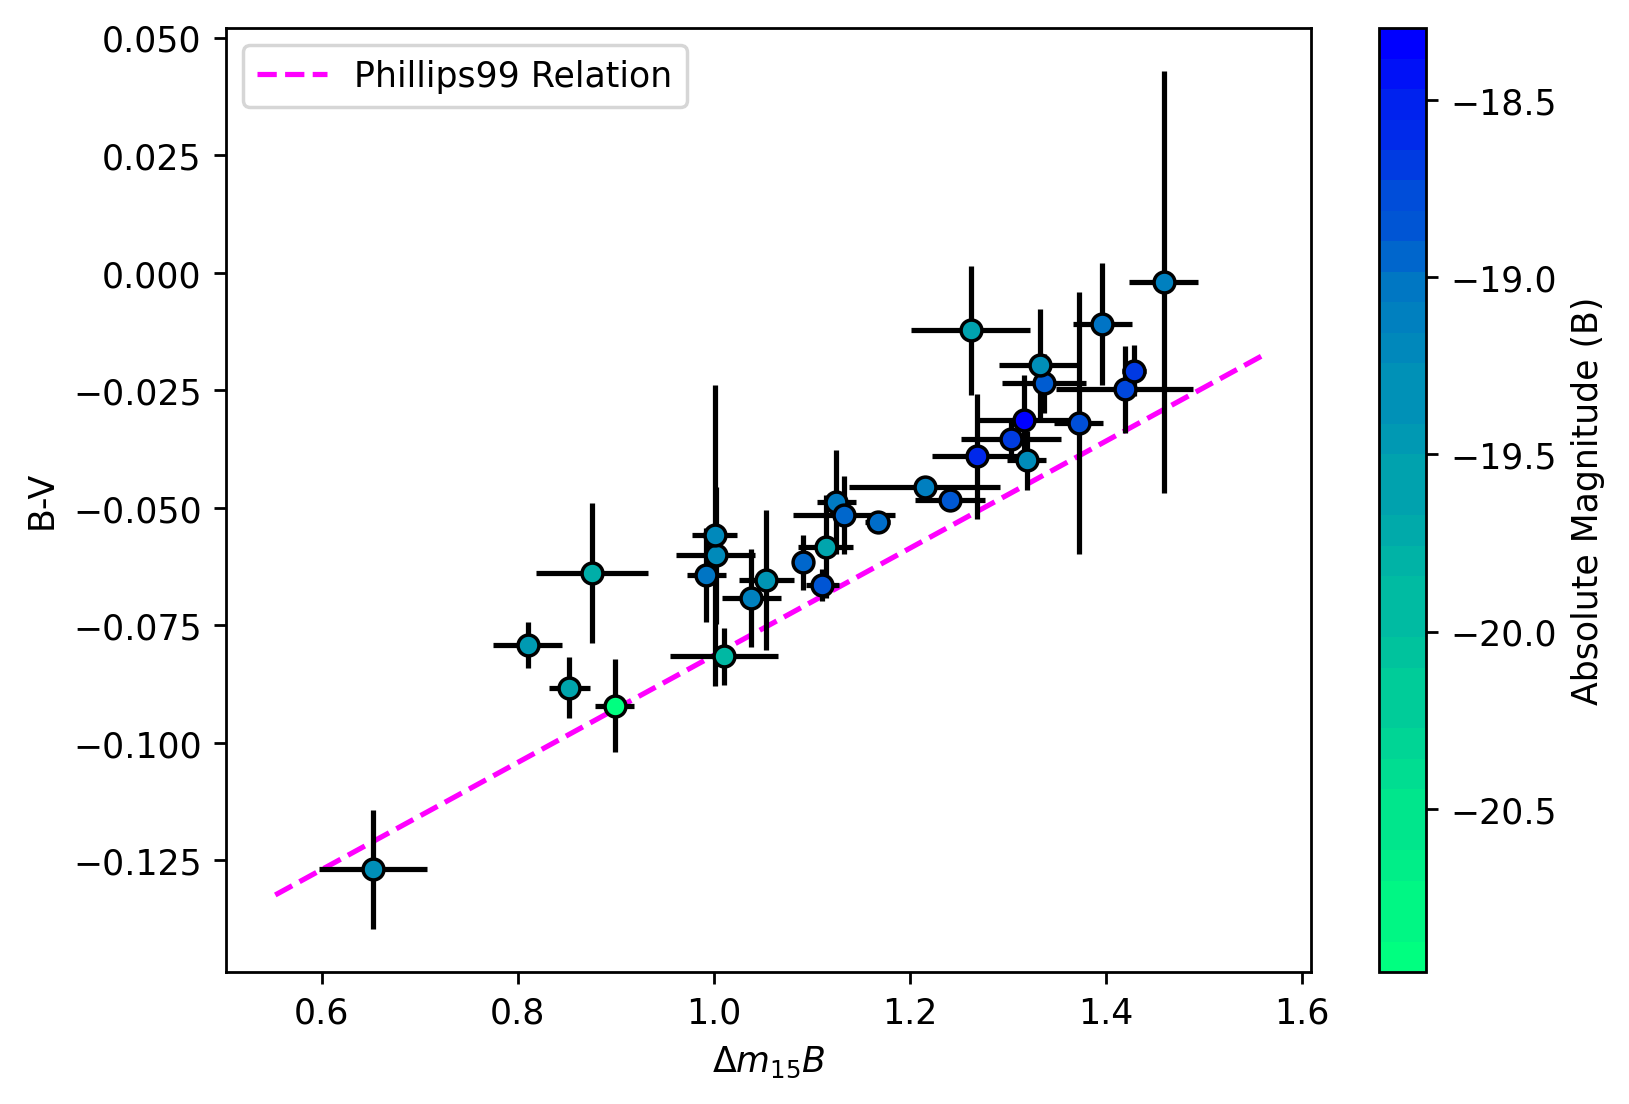

In [14]:
plt.figure(1,figsize=(7,5),dpi=250)
dx = dmz
dy = BT-VT
dz = BT
dxe = dmze
dye = np.sqrt(EB**2 + EV**2)

nbt = []
for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    nbt.append(dz[i]-dismo_n[i])
#dz = nbt
nbt = np.asarray(nbt)
print(np.min(nbt))
divnorm2 = colors.TwoSlopeNorm(vmin=np.min(nbt), vcenter=np.median(nbt), vmax=np.max(nbt))
mycmap2 = plt.get_cmap('winter_r')(divnorm2(nbt))
smap2 = plt.get_cmap('winter_r',len(nbt))   
for i in range(len(zed)):
        plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='Absolute Magnitude (B)')
plt.xlabel('$\Delta m_{15}B$')
plt.ylabel('B-V')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)


# def linear(x,a,b):
#     return a*(x-1.1)+b
# la, lb = [],[]
# for i in range(1000):
#     g2 = np.random.normal(dy,dye)
#     g1 = np.random.normal(dx,dxe)
#     popt, pcov = curve_fit(linear, g1, g2)
#     la.append(popt[0])
#     lb.append(popt[1])

# print(np.mean(la),np.std(la))
# print(np.mean(lb),np.std(lb))
# print(popt,pcov)

# plt.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')

# for i in range(1000):
#     if i == 1:
#         plt.plot([1.0,1.00000001], [-.07,-.07000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#     else:
#         plt.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
        
plt.plot(nxs, 0.114*(nxs-1.1)-0.07,color='magenta',linestyle='--',zorder=2, label='Phillips99 Relation')

plt.legend(loc='upper left')
#plt.gca().invert_yaxis()
#plt.show()
plt.savefig('outputs_color/all_optiphil99_3.png',facecolor='white')

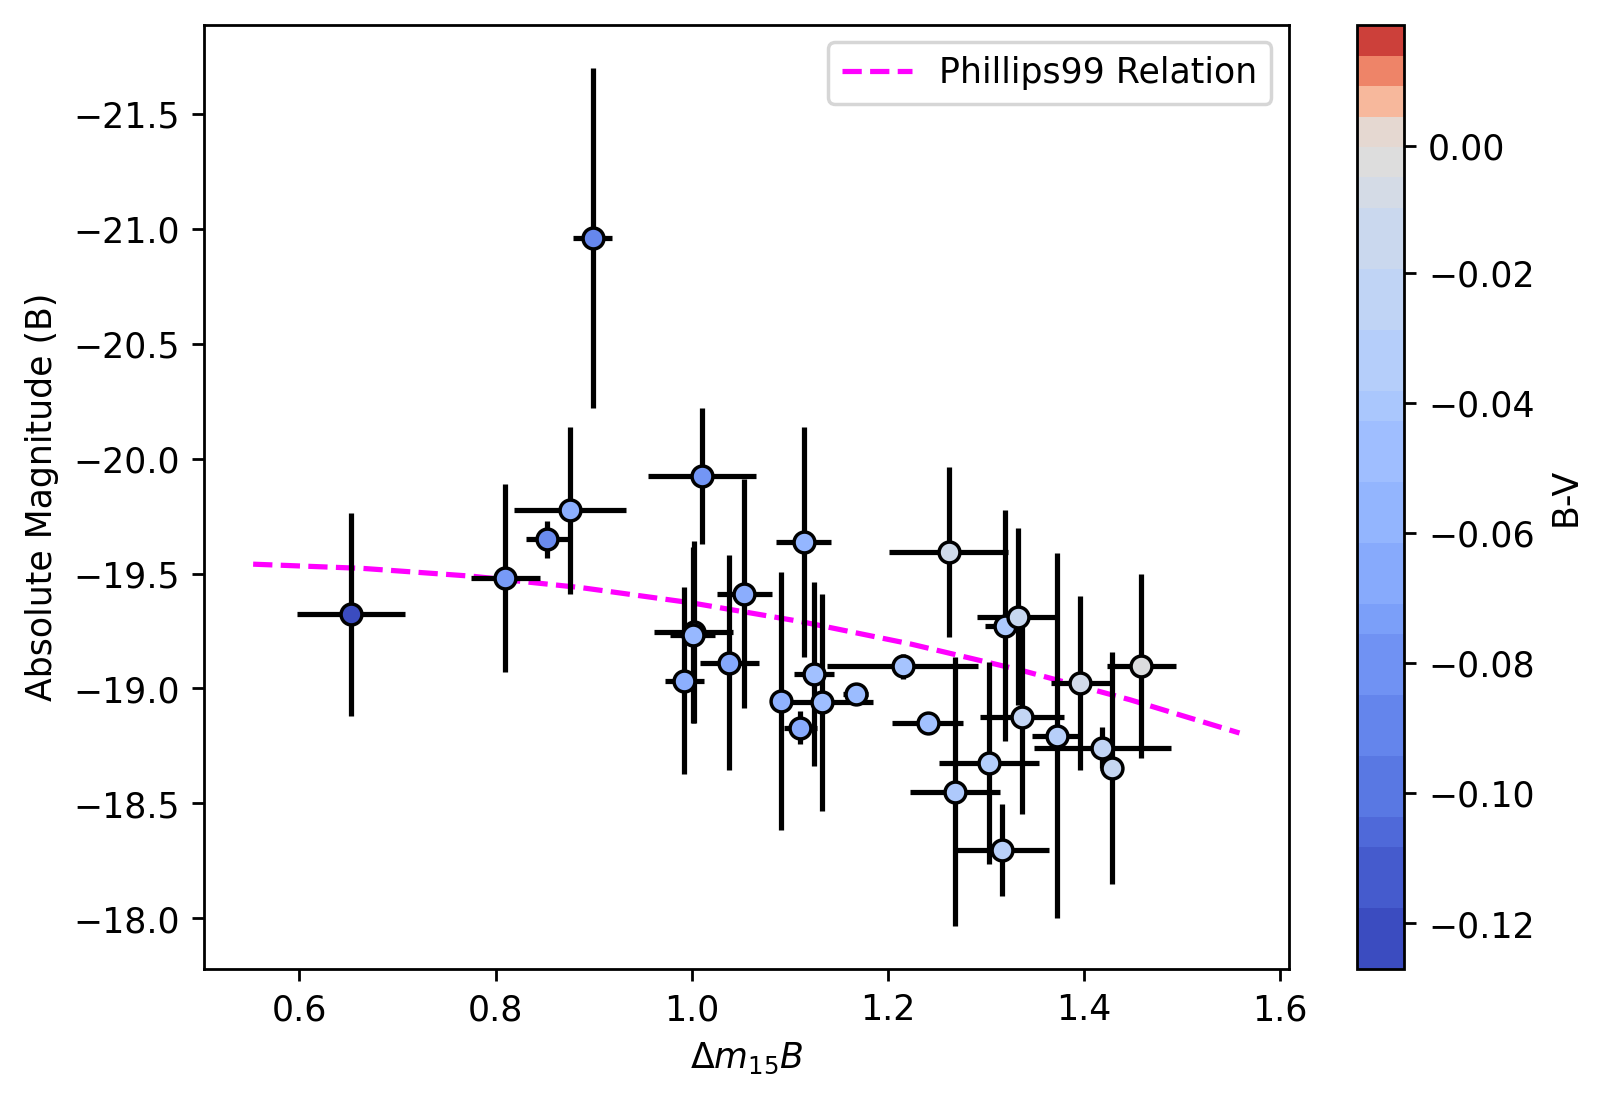

In [15]:
plt.figure(1,figsize=(7,5),dpi=250)
dx = dmz
dy = BT
dz = BT-VT
dxe = dmze
dye = np.sqrt(EB**2 + dismo_e**2)
print(dz)
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=0.0, vmax=max(dz)+0.02)
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))

nbt = []
for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i]-dismo_n[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo_n[i])
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='B-V')
plt.xlabel('$\Delta m_{15}B$')
plt.ylabel('Absolute Magnitude (B)')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)


def linear(x,a,b,c):
    return a*(x-1.1) + b*(x-1.1)**2 +c
# la, lb, lc =   [],[],[]
# for i in range(1000):
#     g2 = np.random.normal(nbt,dye)
#     g1 = np.random.normal(dx,dxe)
#     popt, pcov = curve_fit(linear, g1, g2)
#     la.append(popt[0])
#     lb.append(popt[1])
#     lc.append(popt[2])

# print(np.mean(la),np.std(la))
# print(np.mean(lb),np.std(lb))
# print(np.mean(lc),np.std(lc))
# print(popt,pcov)

# plt.plot(nxs, linear(nxs,np.mean(la),np.mean(lb),np.mean(lc)),color='gold',linestyle='-.',zorder=2, label='Best Fit')

# for i in range(1000):
#     if i == 1:
#         plt.plot([1.0,1.00000001], [-19.5,-19.5000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
# #         print('hi')
#     else:
#         plt.plot(nxs, linear(nxs,la[i],lb[i],lc[i]),color='gray',alpha=0.01,zorder=1)


#plt.plot(nxs, 2.698*(nxs)-21.726,color='magenta',linestyle='--',zorder=2, label='Phillips93 Relation')
plt.plot(nxs, (0.633*(nxs-1.1)**2) +0.786*(nxs-1.1) -19.3,color='magenta',
         linestyle='--',zorder=2, label='Phillips99 Relation')


plt.legend(loc='best')
plt.gca().invert_yaxis()
# plt.show()
plt.savefig('outputs_color/all_optiphil99_4_v3.png',facecolor='white')
print(len(zed))

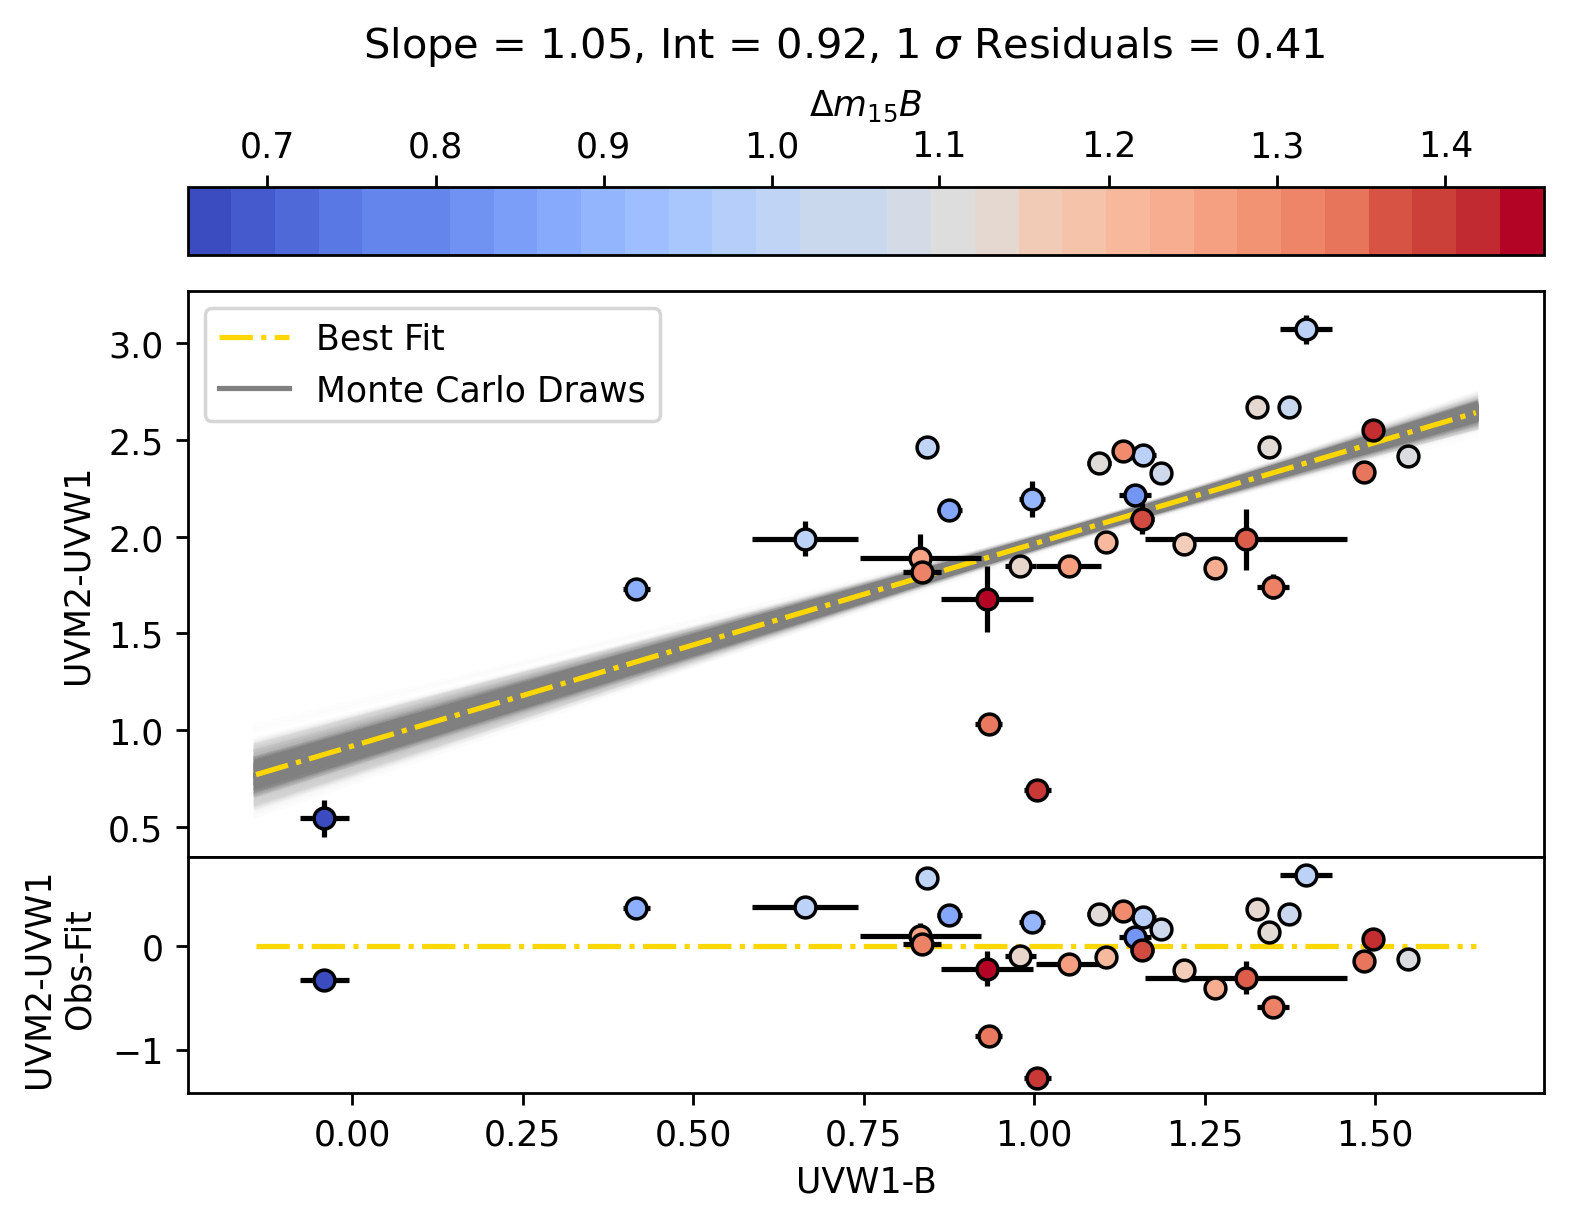

In [20]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dy = M2T-W1T
dx = W1T-BT
dxe = np.sqrt(EW1**2+ EB**2)
dye = np.sqrt(EM2**2+ EW1**2)
gs = plt.GridSpec(2,1,height_ratios=[3, 1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[0])

for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo)
# sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
# cbar.set_label('$\Delta m_{15}B$')

# ax.set_xlabel('UVW1-B')
ax.set_ylabel('UVM2-UVW1')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
ax.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax.set_ylim(min(dy)-0.2, max(dy)+0.2)

def linear(x,a,b):
    return a*x +b
la, lb =   [],[]
for i in range(1000):
    g2 = np.random.normal(dy,dye)
    g1 = np.random.normal(dx,dxe)
    popt, pcov = curve_fit(linear, g1, g2)
    la.append(popt[0])
    lb.append(popt[1])
    #lc.append(popt[2])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
#print(np.mean(lc),np.std(lc))
print(popt,pcov)

ax.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')


for i in range(1000):
    if i == 1:
        ax.plot([1.0,1.00000001], [3.0,3.0000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#         print('hi')
    else:
        ax.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
ax.legend(loc='upper left')
ax2 = fig.add_subplot(gs[1], sharex=ax)

hari = []
for i in range(len(dx)):
    kane = linear(dx[i],np.mean(la),np.mean(lb))
    ax2.errorbar(x=dx[i],y=dy[i]-kane,yerr=dye[i], xerr=dxe[i],ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=2)
    hari.append(dy[i]-kane)
ax2.plot(nxs,0*np.asarray(nxs),color='gold',linestyle='-.',zorder=1)
ax2.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax2.set_xlabel('UVW1-B')
ax2.set_ylabel('UVM2-UVW1 \n Obs-Fit')
print(np.std(hari))
fig.suptitle('Slope = '+str(round(np.mean(la),2))+', Int = '+str(round(np.mean(lb),2))+', 1 $\sigma$ Residuals = '+str(round(np.std(hari),2)))
#fig.tight_layout()
fig.subplots_adjust(hspace=0)
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
cbar.set_label('$\Delta m_{15}B$')
#plt.gca().invert_yaxis()
plt.show()
# plt.savefig('outputs/all_m2w1b.png',facecolor='white')

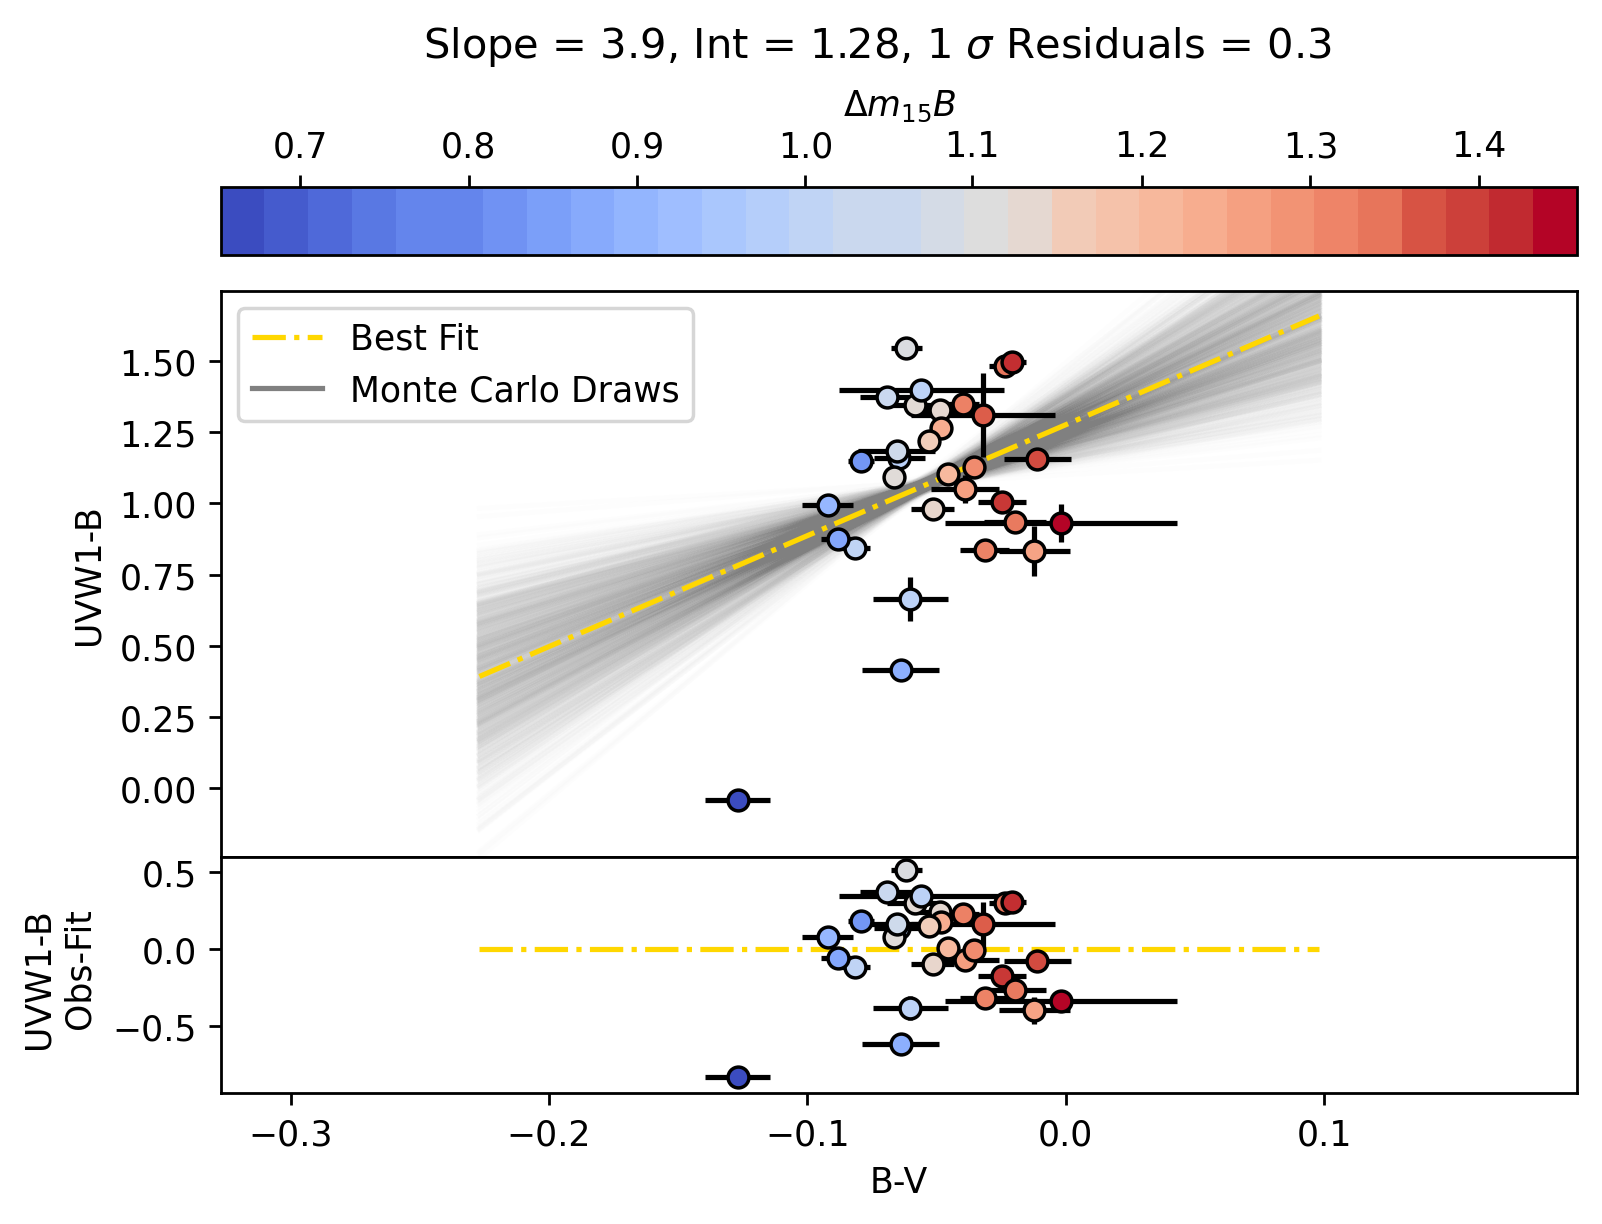

In [19]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dx = BT-VT
dy = W1T-BT
dye = np.sqrt(EW1**2+ EB**2)
dxe = np.sqrt(EV**2+ EB**2)
gs = plt.GridSpec(2,1,height_ratios=[3, 1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[0])

for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo)
# sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
# cbar.set_label('$\Delta m_{15}B$')

# ax.set_xlabel('UVW1-B')
ax.set_ylabel('UVW1-B')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
ax.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax.set_ylim(min(dy)-0.2, max(dy)+0.2)

def linear(x,a,b):
    return a*x +b
la, lb =   [],[]
for i in range(1000):
    g2 = np.random.normal(dy,dye)
    g1 = np.random.normal(dx,dxe)
    popt, pcov = curve_fit(linear, g1, g2)
    la.append(popt[0])
    lb.append(popt[1])
    #lc.append(popt[2])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
#print(np.mean(lc),np.std(lc))
print(popt,pcov)

ax.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')


for i in range(1000):
    if i == 1:
        ax.plot([1.0,1.00000001], [3.0,3.0000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#         print('hi')
    else:
        ax.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
ax.legend(loc='upper left')
ax2 = fig.add_subplot(gs[1], sharex=ax)

hari = []
for i in range(len(dx)):
    kane = linear(dx[i],np.mean(la),np.mean(lb))
    ax2.errorbar(x=dx[i],y=dy[i]-kane,yerr=dye[i], xerr=dxe[i],ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=2)
    hari.append(dy[i]-kane)
ax2.plot(nxs,0*np.asarray(nxs),color='gold',linestyle='-.',zorder=1)
ax2.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax2.set_xlabel('B-V')
ax2.set_ylabel('UVW1-B \n Obs-Fit')
print(np.std(hari))
fig.suptitle('Slope = '+str(round(np.mean(la),2))+', Int = '+str(round(np.mean(lb),2))+', 1 $\sigma$ Residuals = '+str(round(np.std(hari),2)))
#fig.tight_layout()
fig.subplots_adjust(hspace=0)
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
cbar.set_label('$\Delta m_{15}B$')
#plt.gca().invert_yaxis()
plt.show()
# plt.savefig('outputs/all_m2w1b.png',facecolor='white')

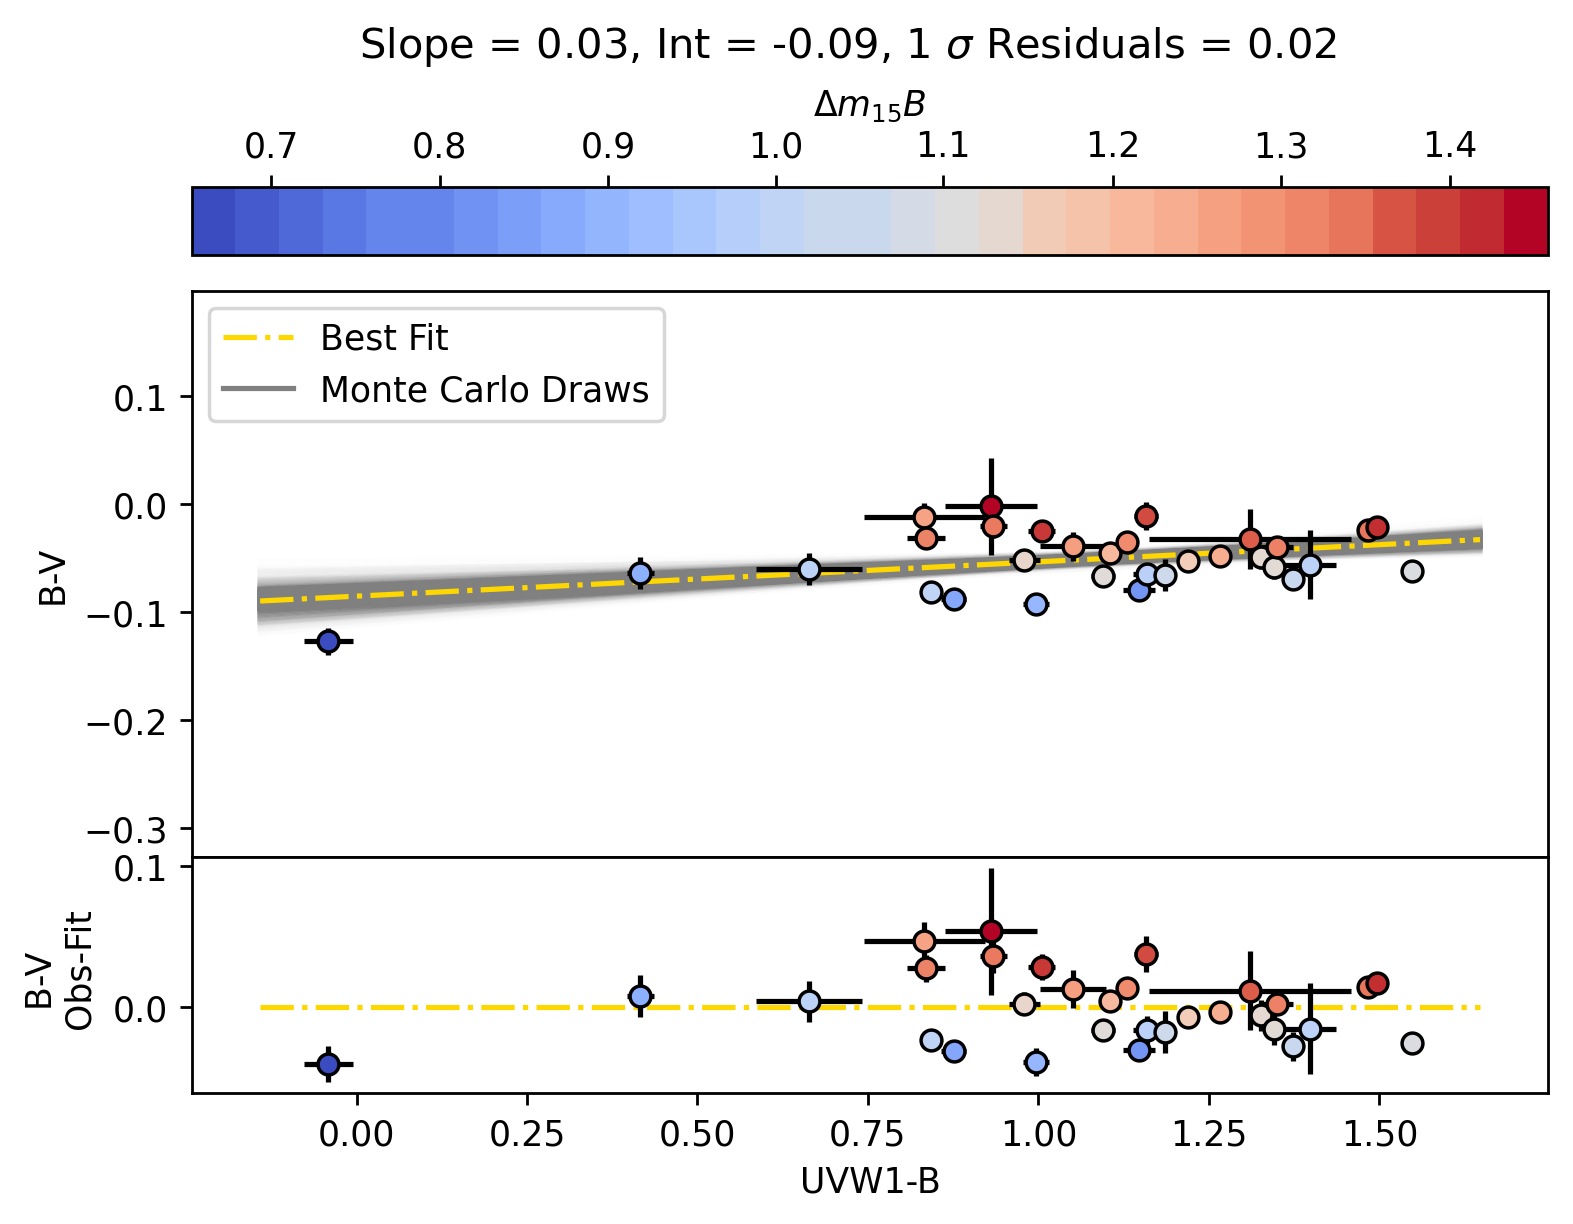

In [21]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dy = BT-VT
dx = W1T-BT
dxe = np.sqrt(EW1**2+ EB**2)
dye = np.sqrt(EV**2+ EB**2)
gs = plt.GridSpec(2,1,height_ratios=[3, 1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[0])

for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo)
# sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
# cbar.set_label('$\Delta m_{15}B$')

# ax.set_xlabel('UVW1-B')
ax.set_ylabel('B-V')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
ax.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax.set_ylim(min(dy)-0.2, max(dy)+0.2)

def linear(x,a,b):
    return a*x +b
la, lb =   [],[]
for i in range(1000):
    g2 = np.random.normal(dy,dye)
    g1 = np.random.normal(dx,dxe)
    popt, pcov = curve_fit(linear, g1, g2)
    la.append(popt[0])
    lb.append(popt[1])
    #lc.append(popt[2])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
#print(np.mean(lc),np.std(lc))
print(popt,pcov)

ax.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')


for i in range(1000):
    if i == 1:
        ax.plot([1.0,1.00000001], [3.0,3.0000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#         print('hi')
    else:
        ax.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
ax.legend(loc='upper left')
ax2 = fig.add_subplot(gs[1], sharex=ax)

hari = []
for i in range(len(dx)):
    kane = linear(dx[i],np.mean(la),np.mean(lb))
    ax2.errorbar(x=dx[i],y=dy[i]-kane,yerr=dye[i], xerr=dxe[i],ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=2)
    hari.append(dy[i]-kane)
ax2.plot(nxs,0*np.asarray(nxs),color='gold',linestyle='-.',zorder=1)
ax2.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax2.set_xlabel('UVW1-B')
ax2.set_ylabel('B-V \n Obs-Fit')
print(np.std(hari))
fig.suptitle('Slope = '+str(round(np.mean(la),2))+', Int = '+str(round(np.mean(lb),2))+', 1 $\sigma$ Residuals = '+str(round(np.std(hari),2)))
#fig.tight_layout()
fig.subplots_adjust(hspace=0)
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
cbar = plt.colorbar(sm1, ax=[ax], location = 'top')
cbar.set_label('$\Delta m_{15}B$')
#plt.gca().invert_yaxis()
plt.show()
# plt.savefig('outputs/all_m2w1b.png',facecolor='white')

1.0439377916345507 0.033699867808289326
-19.393698758612352 0.1002177865573782
[  0.99154493 -19.25215645] [[ 0.00738439 -0.02088369]
 [-0.02088369  0.06493786]]
0.44699986779759915


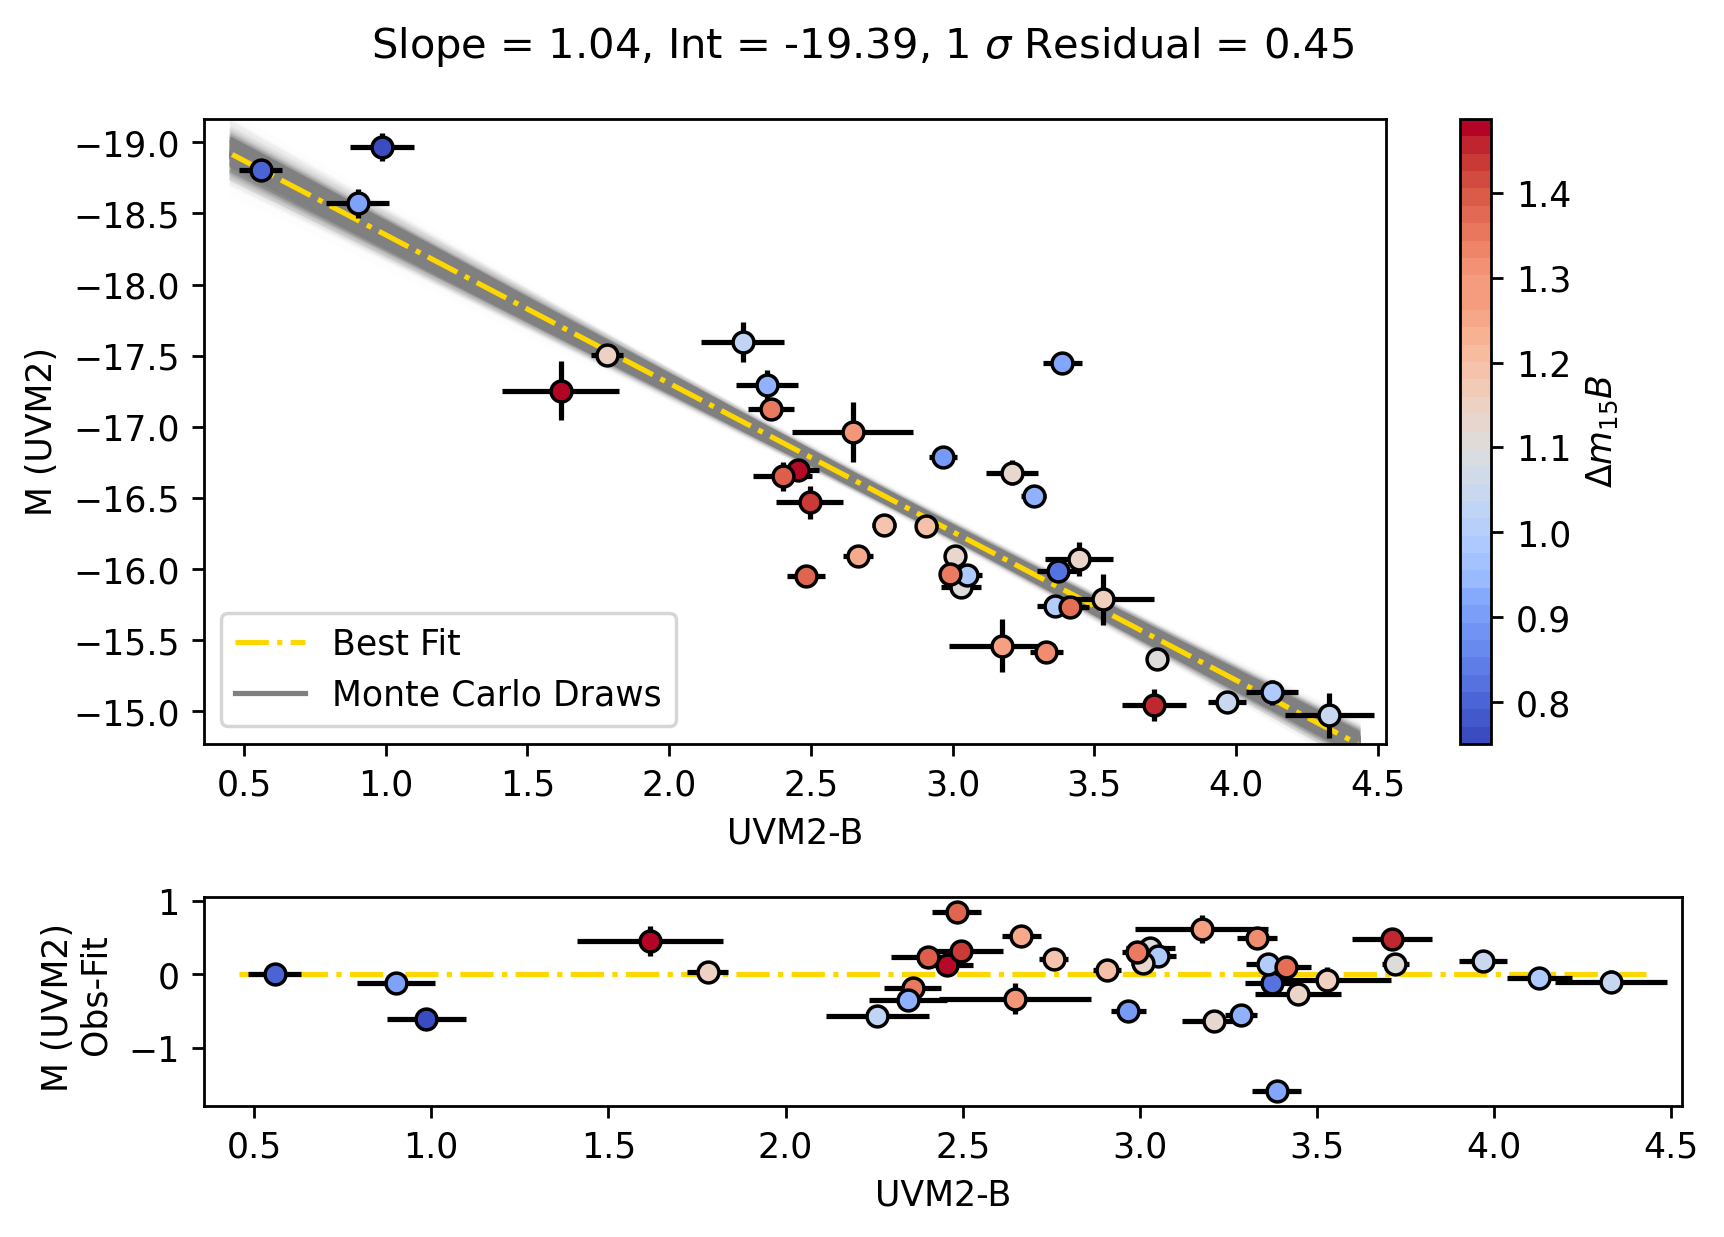

In [26]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dy = np.sqrt(M2T**2 + dismo_e**2)
dx = M2T-BT
dxe = np.sqrt(EM2**2+ EB**2)
dye = EM2
gs = plt.GridSpec(2,1,height_ratios=[3, 1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[0])
nbt = []
for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i]-dismo_n[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo_n[i])
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# ax.set_colorbar(sm1,label='$\Delta m_{15}B$')
cbar = plt.colorbar(sm1)
cbar.set_label('$\Delta m_{15}B$')
ax.set_xlabel('UVM2-B')
ax.set_ylabel('M (UVM2)')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
ax.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax.set_ylim(max(nbt)+0.2, min(nbt)-0.2)

def linear(x,a,b):
    return a*x +b
la, lb =   [],[]
for i in range(1000):
    g2 = np.random.normal(nbt,dye)
    g1 = np.random.normal(dx,dxe)
    popt, pcov = curve_fit(linear, g1, g2)
    la.append(popt[0])
    lb.append(popt[1])
    #lc.append(popt[2])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
#print(np.mean(lc),np.std(lc))
print(popt,pcov)

ax.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')

for i in range(1000):
    if i == 1:
        ax.plot([1.0,1.00000001], [-19.5,-19.5000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#         print('hi')
    else:
        ax.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
ax.legend(loc='lower left')
# .gca().invert_yaxis()
ax = fig.add_subplot(gs[1])
hari = []
for i in range(len(dx)):
    kane = linear(dx[i],np.mean(la),np.mean(lb))
    ax.errorbar(x=dx[i],y=nbt[i]-kane,yerr=dye[i], xerr=dxe[i],ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=2)
    hari.append(nbt[i]-kane)
ax.plot(nxs,0*np.asarray(nxs),color='gold',linestyle='-.',zorder=1)
ax.set_xlim(min(dx)-0.2, max(dx)+0.2)
ax.set_xlabel('UVM2-B')
ax.set_ylabel('M (UVM2) \n Obs-Fit')
print(np.std(hari))
fig.suptitle('Slope = '+str(round(np.mean(la),2))+', Int = '+str(round(np.mean(lb),2))+', 1 $\sigma$ Residual = '+str(round(np.std(hari),2)))
fig.tight_layout()

#plt.gca().invert_yaxis()
plt.show()
# plt.savefig('outputs/all_colmag_m2b_v2.png',facecolor='white')

0.19581297570245015 0.07929957462637789
-16.05476410615899 1.304343051683583
[  0.28158781 -14.6656505 ] [[0.00856692 0.14157476]
 [0.14157476 2.3498173 ]]
0.3821131198653565


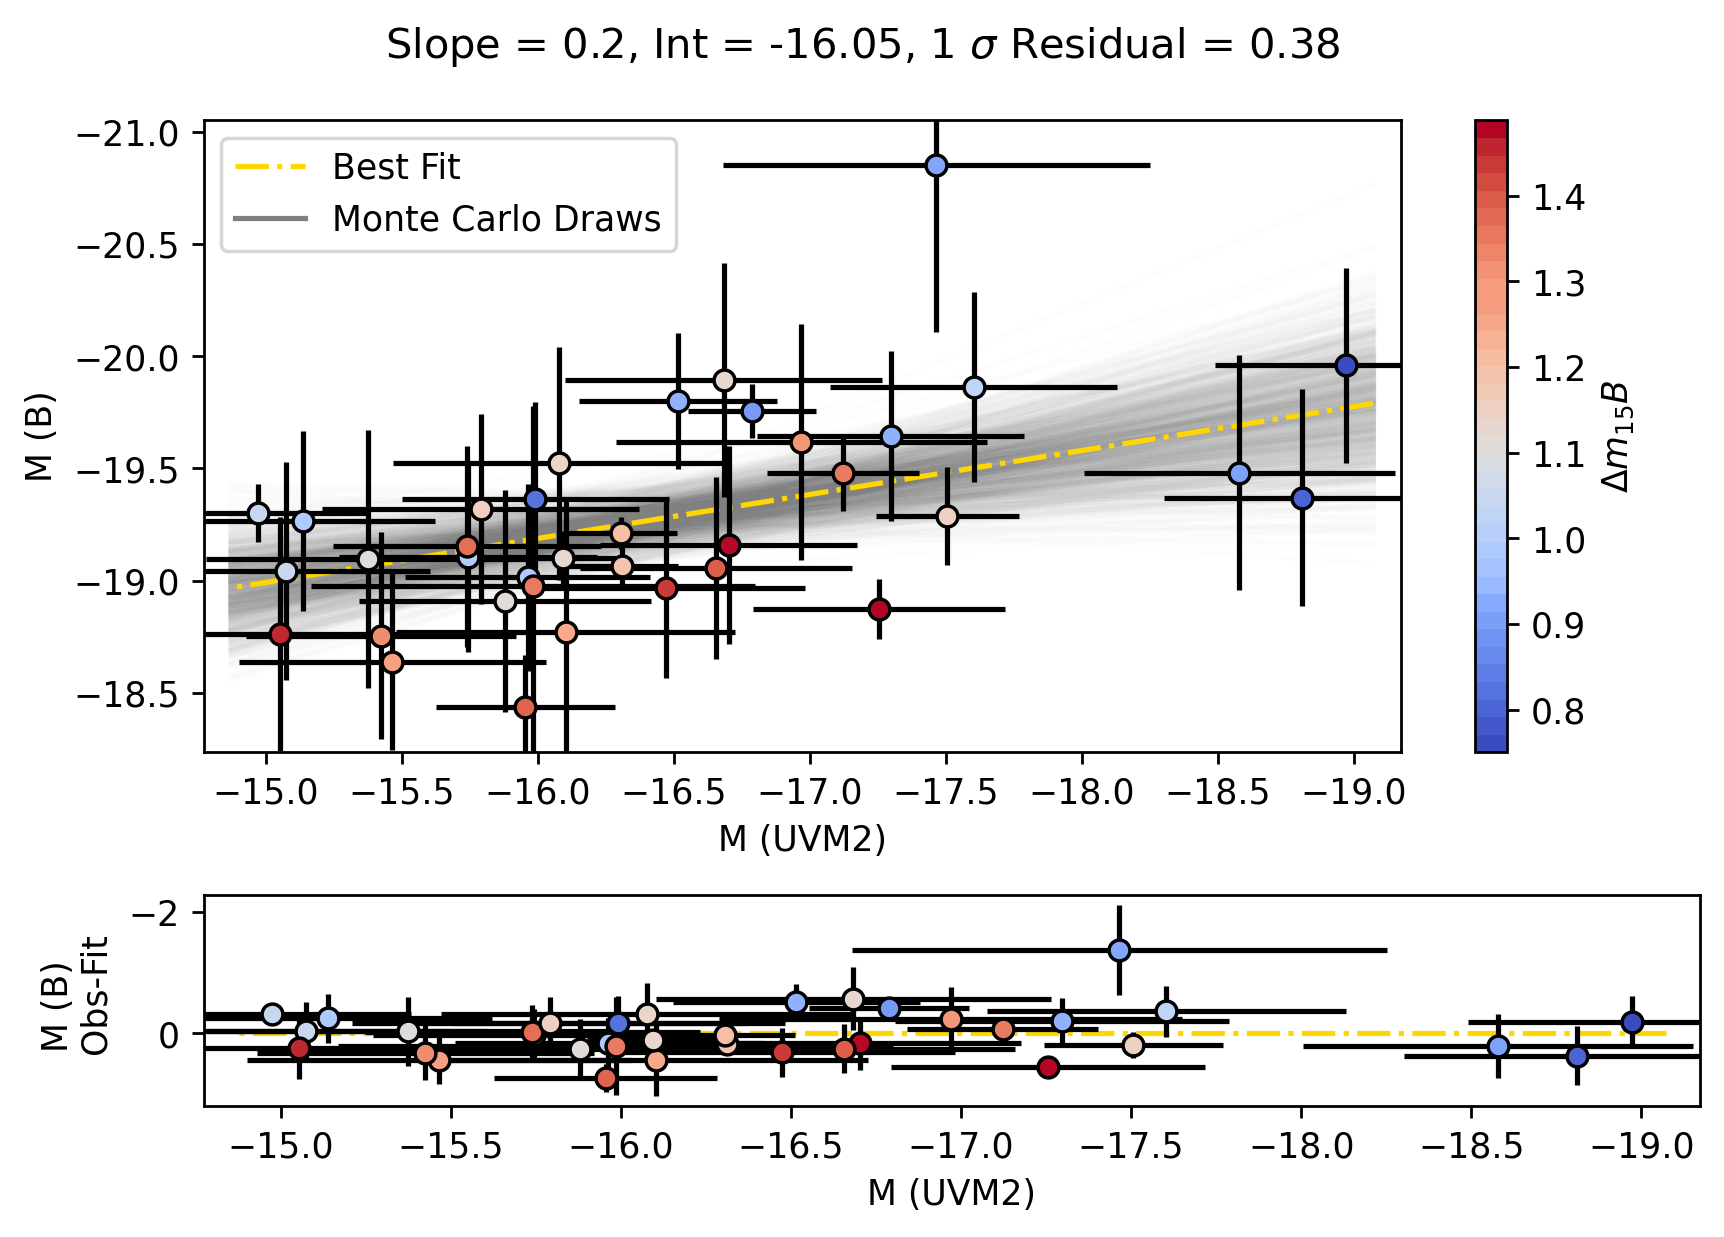

In [27]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dy = BT
dx = M2T
dxe = np.sqrt(EM2 + dismo_e**2)
dye = np.sqrt(EB + dismo_e**2)
gs = plt.GridSpec(2,1,height_ratios=[3, 1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[0])
nbt , nut = [], []
for i in range(len(zed)):
#     par = fff[i].value
#     dismo = 5*np.log10(par*(10**5))
    plt.errorbar(x=dx[i]-dismo_n[i], y=dy[i]-dismo_n[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo_n[i])
    nut.append(dx[i]-dismo_n[i])
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# ax.set_colorbar(sm1,label='$\Delta m_{15}B$')
cbar = plt.colorbar(sm1)
cbar.set_label('$\Delta m_{15}B$')
ax.set_xlabel('M (UVM2)')
ax.set_ylabel('M (B)')
nxs = np.linspace(min(nut)-.1,max(nut)+.1,10)
ax.set_xlim(max(nut)+0.2, min(nut)-0.2)
ax.set_ylim(max(nbt)+0.2, min(nbt)-0.2)

def linear(x,a,b):
    return a*x +b
la, lb =   [],[]
for i in range(1000):
    g2 = np.random.normal(nbt,dye)
    g1 = np.random.normal(nut,dxe)
    popt, pcov = curve_fit(linear, g1, g2)
    la.append(popt[0])
    lb.append(popt[1])
    #lc.append(popt[2])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
#print(np.mean(lc),np.std(lc))
print(popt,pcov)

ax.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2, label='Best Fit')

for i in range(1000):
    if i == 1:
        ax.plot([-19.0,-19.00000001], [-19.5,-19.5000001],color='gray',alpha=1,zorder=1,label='Monte Carlo Draws')
#         print('hi')
    else:
        ax.plot(nxs, linear(nxs,la[i],lb[i]),color='gray',alpha=0.01,zorder=1)
ax.legend(loc='upper left')
# .gca().invert_yaxis()
ax = fig.add_subplot(gs[1])
hari = []
for i in range(len(dx)):
    kane = linear(nut[i],np.mean(la),np.mean(lb))
    ax.errorbar(x=nut[i],y=nbt[i]-kane,yerr=dye[i], xerr=dxe[i],ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=2)
    hari.append(nbt[i]-kane)
ax.plot(nxs,0*np.asarray(nxs),color='gold',linestyle='-.',zorder=1)
ax.set_xlim(max(nut)+0.2, min(nut)-0.2)

ax.set_xlabel('M (UVM2)')
ax.set_ylabel('M (B) \n Obs-Fit')
print(np.std(hari))
fig.suptitle('Slope = '+str(round(np.mean(la),2))+', Int = '+str(round(np.mean(lb),2))+', 1 $\sigma$ Residual = '+str(round(np.std(hari),2)))
fig.tight_layout()
#print(hari)
plt.gca().invert_yaxis()
plt.show()
# plt.savefig('outputs/all_absbm2_V2.png',facecolor='white')

/Users/yaswantd/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/yaswantd/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yaswantd/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/yaswantd/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yaswantd/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


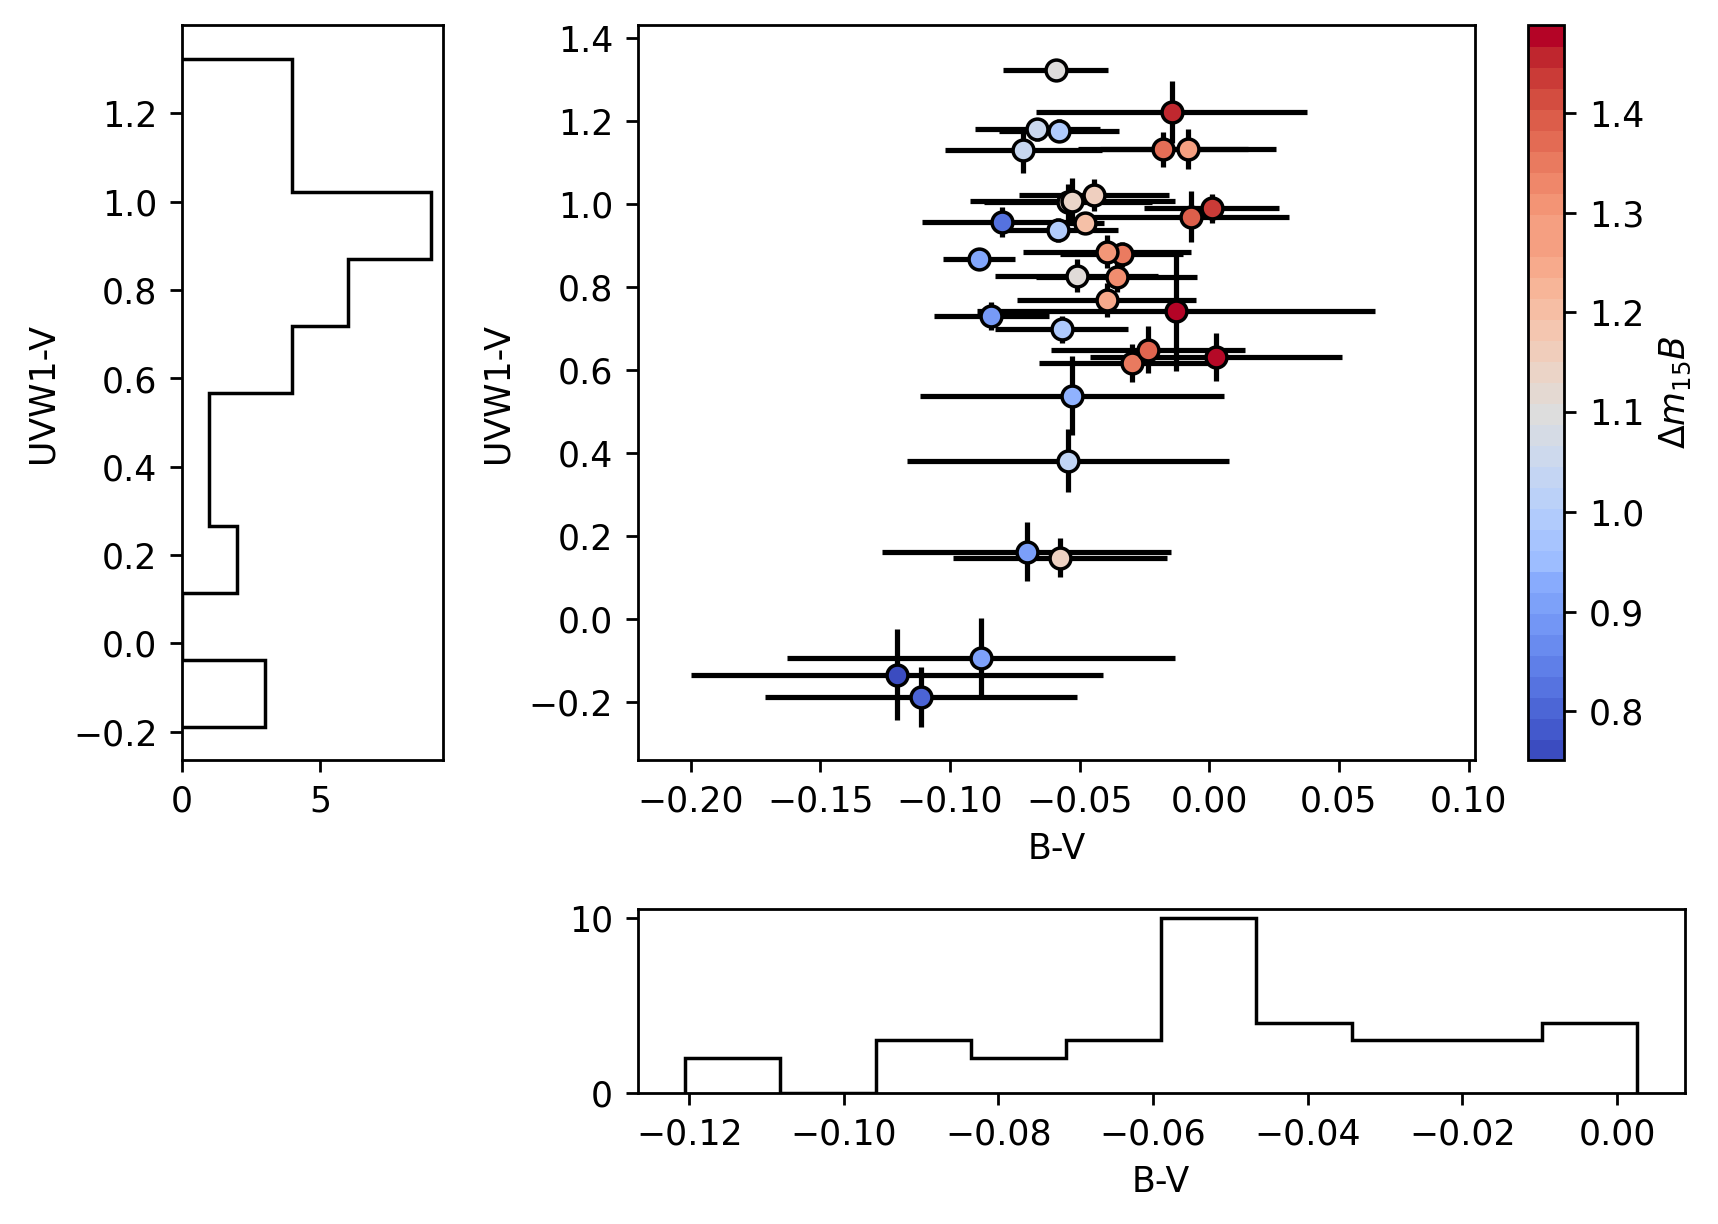

In [24]:
fig = plt.figure(1,figsize=(7,5),dpi=250)
dz = dmz
dy = W1T-VT
dx = BT-VT
dxe = np.sqrt(EV**2+ EB**2)
dye = np.sqrt(EW1**2+ EV**2)
gs = plt.GridSpec(2,2,width_ratios=[1,4],height_ratios=[4,1])
divnorm2 = colors.TwoSlopeNorm(vmin=min(dz), vcenter=1.1, vmax=max(dz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dz))
smap2 = plt.get_cmap('coolwarm',len(dz))
ax = fig.add_subplot(gs[1])
nbt = []
for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    plt.errorbar(dx[i], dy[i],yerr=dye[i],xerr=dxe[i],ecolor='black',marker='o',
                 mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(dy[i]-dismo)
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
# ax.set_colorbar(sm1,label='$\Delta m_{15}B$')
cbar = plt.colorbar(sm1)
cbar.set_label('$\Delta m_{15}B$')
ax.set_xlabel('B-V')
ax.set_ylabel('UVW1-V')
nxs = np.linspace(min(dx)-.1,max(dx)+.1,10)
ax.set_xlim(min(dx)-0.1, max(dx)+0.1)


ax = fig.add_subplot(gs[3])
ax.hist(dx,histtype='step',color='black')
ax.set_xlabel('B-V')
# ax.set_xlim(min(dx)-0.1, max(dx)+0.1)

ax = fig.add_subplot(gs[0])
ax.hist(dy, orientation='horizontal',histtype='step',color='black')
ax.set_ylabel('UVW1-V')

fig.tight_layout()

#plt.gca().invert_yaxis()
# plt.show()
plt.savefig('outputs/all_nouvsplit.png',facecolor='white')

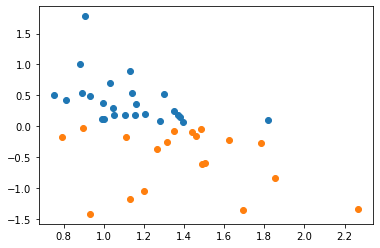

In [131]:
plt.scatter(gaga1,simi1)
plt.scatter(gaga2,simi2)

0.1195009361865641 0.019955127239009943
-0.18730820015138613 0.02529834434173392
[ 0.12692366 -0.19136581] [[ 0.00041038 -0.00051076]
 [-0.00051076  0.00067988]]


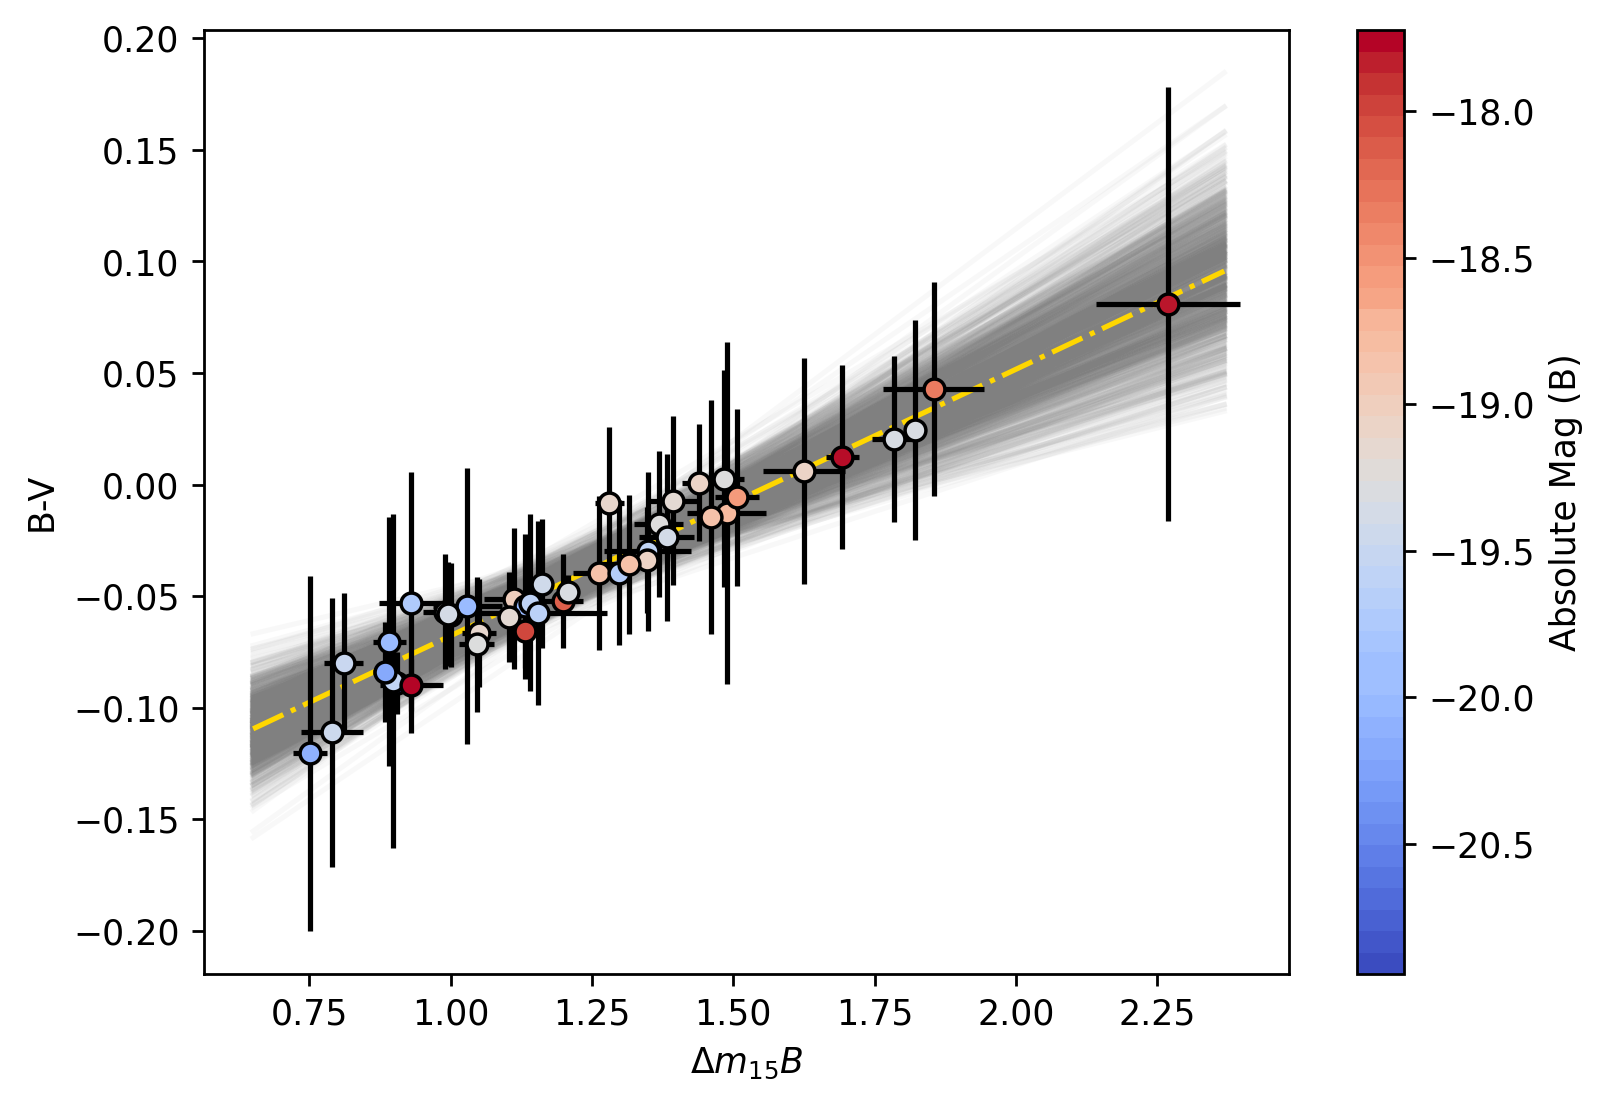

In [109]:
plt.figure(1,figsize=(7,5),dpi=250)
yar = BT-VT


nbt = []
for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    nbt.append(BT[i]-dismo)
    
divnorm2 = colors.TwoSlopeNorm(vmin=min(nbt), vcenter=np.median(nbt), vmax=max(nbt))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(nbt))
smap2 = plt.get_cmap('coolwarm',len(nbt))
for i in range(len(zed)):
    plt.errorbar(dmz[i], yar[i],yerr=np.sqrt(EB[i]**2 + EV[i]**2),xerr=dmze[i],
                 ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=3)
    
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='Absolute Mag (B)')
plt.xlabel('$\Delta m_{15}B$')
plt.ylabel('B-V')
nxs = np.linspace(min(dmz)-0.1,max(dmz)+0.1,10)
#plt.plot(nxs, 2.698*nxs -21.726, color='k',linestyle='-.')


def linear(x,a,b):
    return a*x+b
popt, pcov = curve_fit(linear, dmz, nbt)
#plt.plot(nxs, linear(nxs,popt[0],popt[1]),color='k')
YE = np.sqrt(EB[i]**2 + EV[i]**2)
la, lb = [],[]
for i in range(1000):
    g2 = np.random.normal(yar,YE)
    g1 = np.random.normal(dmz,dmze)
    popt, pcov = curve_fit(linear, g1, g2)
    plt.plot(nxs, linear(nxs,popt[0],popt[1]),color='gray',alpha=0.05,zorder=1)
    la.append(popt[0])
    lb.append(popt[1])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
print(popt,pcov)
plt.plot(nxs, linear(nxs,np.mean(la),np.mean(lb)),color='gold',linestyle='-.',zorder=2)

#plt.show()
plt.savefig('outputs/all_optiphil2.png',facecolor='white')

0.028748014436441486 0.01114590312956394
0.5131172324469063 0.21491573744334427
[0.02251662 0.40082768] [[0.0001333  0.00255948]
 [0.00255948 0.04920433]]


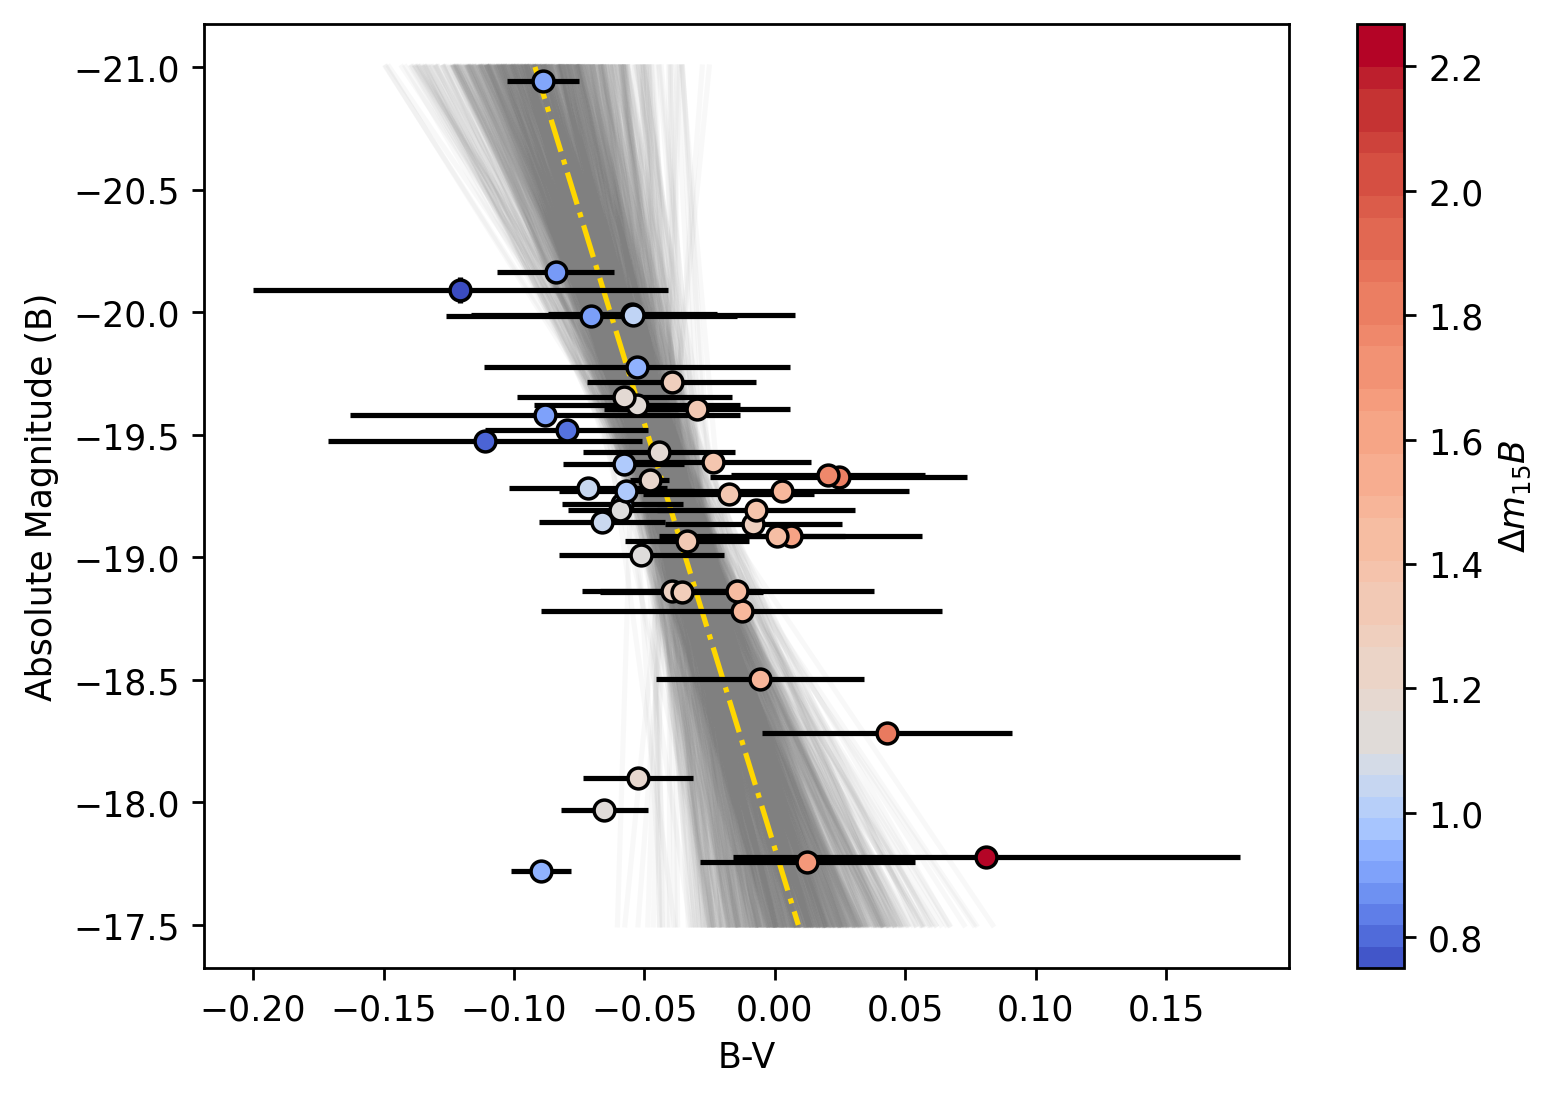

In [103]:
plt.figure(1,figsize=(7,5),dpi=250)
yar = BT-VT
divnorm2 = colors.TwoSlopeNorm(vmin=min(dmz), vcenter=1.1, vmax=max(dmz))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(dmz))
smap2 = plt.get_cmap('coolwarm',len(dmz))
nbt = []


for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    plt.errorbar(x=yar[i], y=BT[i]-dismo,yerr=EB[i],xerr=np.sqrt(EB[i]**2 + EV[i]**2),
                 ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=3)
    nbt.append(BT[i]-dismo)
    #plt.errorbar(yar[i], BT[i]-dismo,yerr=EB[i],ecolor='black',marker='d',mfc=mycmap2[i],mec='black')
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='$\Delta m_{15}B$')
plt.xlabel('B-V')
plt.ylabel('Absolute Magnitude (B)')

xs = np.linspace(-21.0,-17.5,10)
def linear(x,a,b):
    return a*x+b
popt, pcov = curve_fit(linear, nbt, yar)
#plt.plot(xs, linear(xs,popt[0],popt[1]),color='k')
YE = EB
XE = np.sqrt(EB**2 + EV**2)
la, lb = [],[]
for i in range(1000):
    g1 = np.random.normal(yar,XE)
    g2 = np.random.normal(nbt,YE)
    popt, pcov = curve_fit(linear, g2, g1)
    plt.plot( linear(xs,popt[0],popt[1]),xs,color='gray',alpha=0.05,zorder=1)
    la.append(popt[0])
    lb.append(popt[1])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
print(popt,pcov)
plt.plot( linear(xs,np.median(la),np.median(lb)),xs,color='gold',linestyle='-.',zorder=2)

plt.gca().invert_yaxis()
plt.savefig('outputs/all_colmagb2.png',facecolor='white')
#plt.show()

1.223194138985701 0.07883925937546919
-18.414578069660273 0.09375616091593236
[  1.28481273 -18.46823645] [[ 0.18610563 -0.22891373]
 [-0.22891373  0.29916228]]


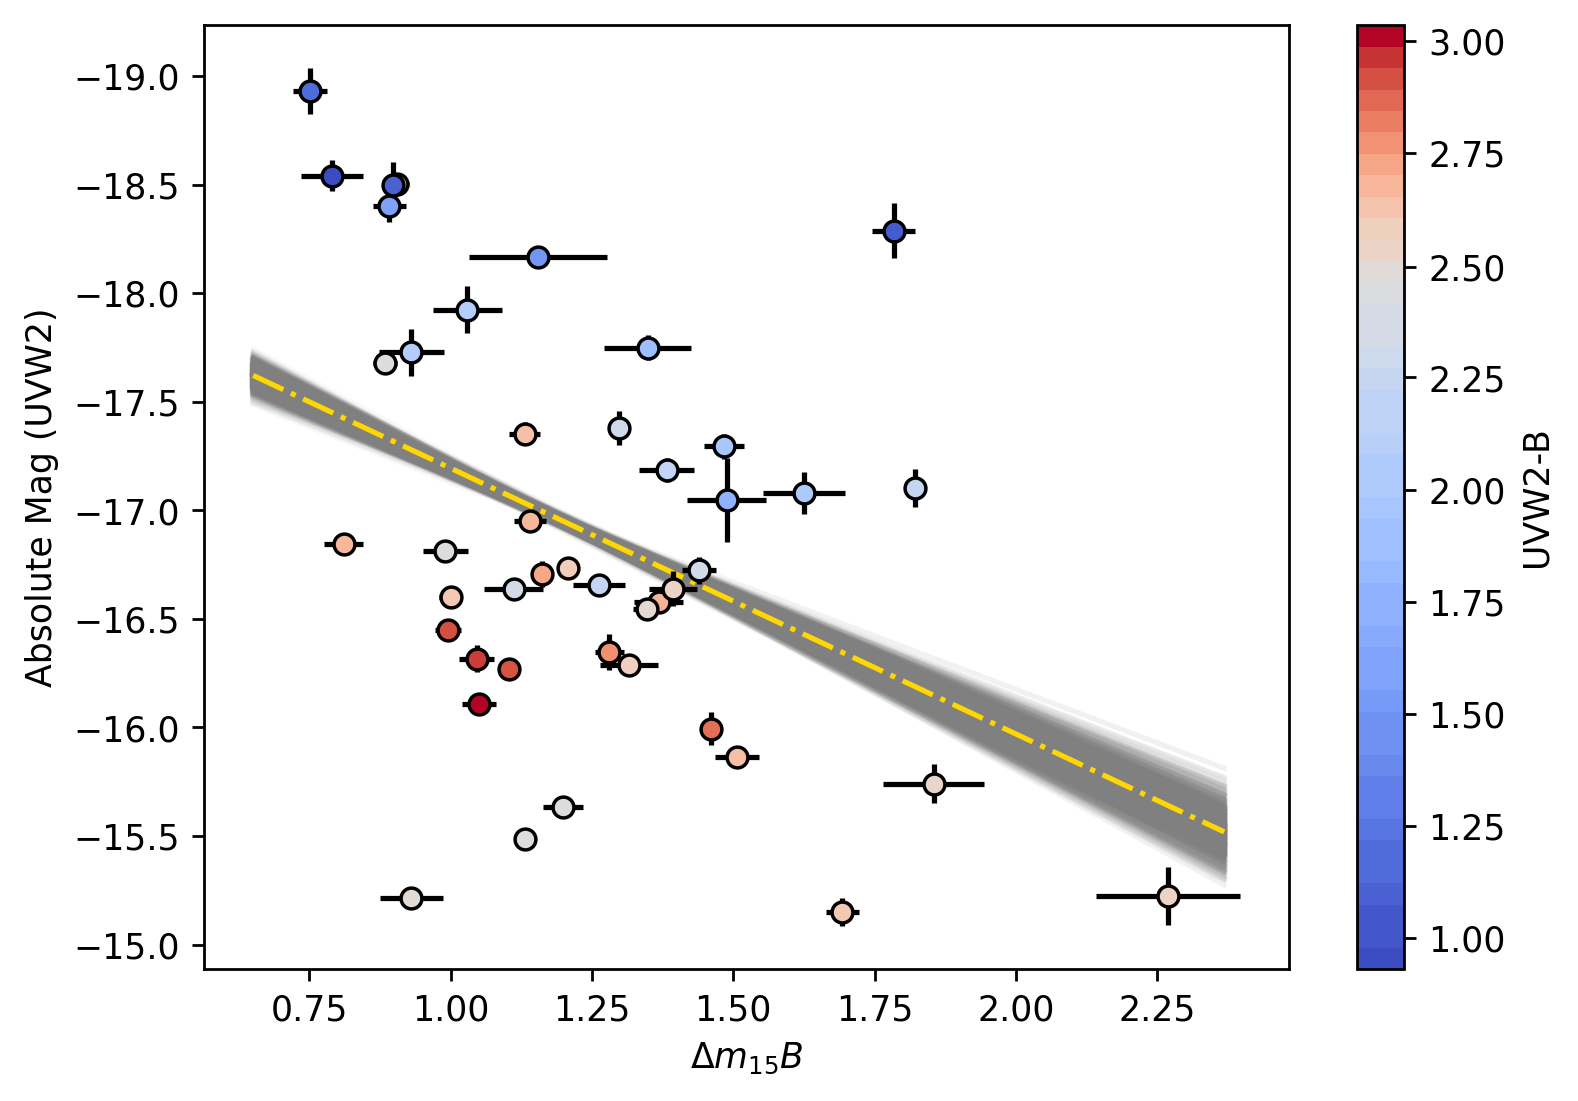

In [108]:
plt.figure(1,figsize=(7,5),dpi=250)
yar = W2T-BT


nbt = []
for i in range(len(zed)):
    par = fff[i].value
    dismo = 5*np.log10(par*(10**5))
    nbt.append(W2T[i]-dismo)
    
divnorm2 = colors.TwoSlopeNorm(vmin=min(yar), vcenter=np.median(yar), vmax=max(yar))
mycmap2 = plt.get_cmap('coolwarm')(divnorm2(yar))
smap2 = plt.get_cmap('coolwarm',len(yar))
for i in range(len(zed)):
    plt.errorbar(dmz[i], nbt[i],yerr=EW2[i], xerr=dmze[i],
                 ecolor='black',marker='o',mfc=mycmap2[i],mec='black',zorder=3)
    
sm1 = plt.cm.ScalarMappable(cmap=smap2, norm=divnorm2)
plt.colorbar(sm1,label='UVW2-B')
plt.xlabel('$\Delta m_{15}B$')
plt.ylabel('Absolute Mag (UVW2)')
nxs = np.linspace(min(dmz)-0.1,max(dmz)+0.1,10)
#plt.plot(nxs, 2.698*nxs -21.726, color='k',linestyle='-.')


def linear(x,a,b):
    return a*x+b
popt, pcov = curve_fit(linear, dmz, nbt)
#plt.plot(nxs, linear(nxs,popt[0],popt[1]),color='k')

la, lb = [],[]
for i in range(1000):
    g2 = np.random.normal(nbt,EW2)
    g1 = np.random.normal(dmz,dmze)
    popt, pcov = curve_fit(linear, g1, g2)
    plt.plot(nxs, linear(nxs,popt[0],popt[1]),color='gray',alpha=0.05,zorder=1)
    la.append(popt[0])
    lb.append(popt[1])

print(np.mean(la),np.std(la))
print(np.mean(lb),np.std(lb))
print(popt,pcov)
plt.plot(nxs, linear(nxs,np.median(la),np.median(lb)),color='gold',linestyle='-.',zorder=2)

plt.gca().invert_yaxis()
plt.show()
#plt.savefig('outputs/all_optiphil2.png',facecolor='white')

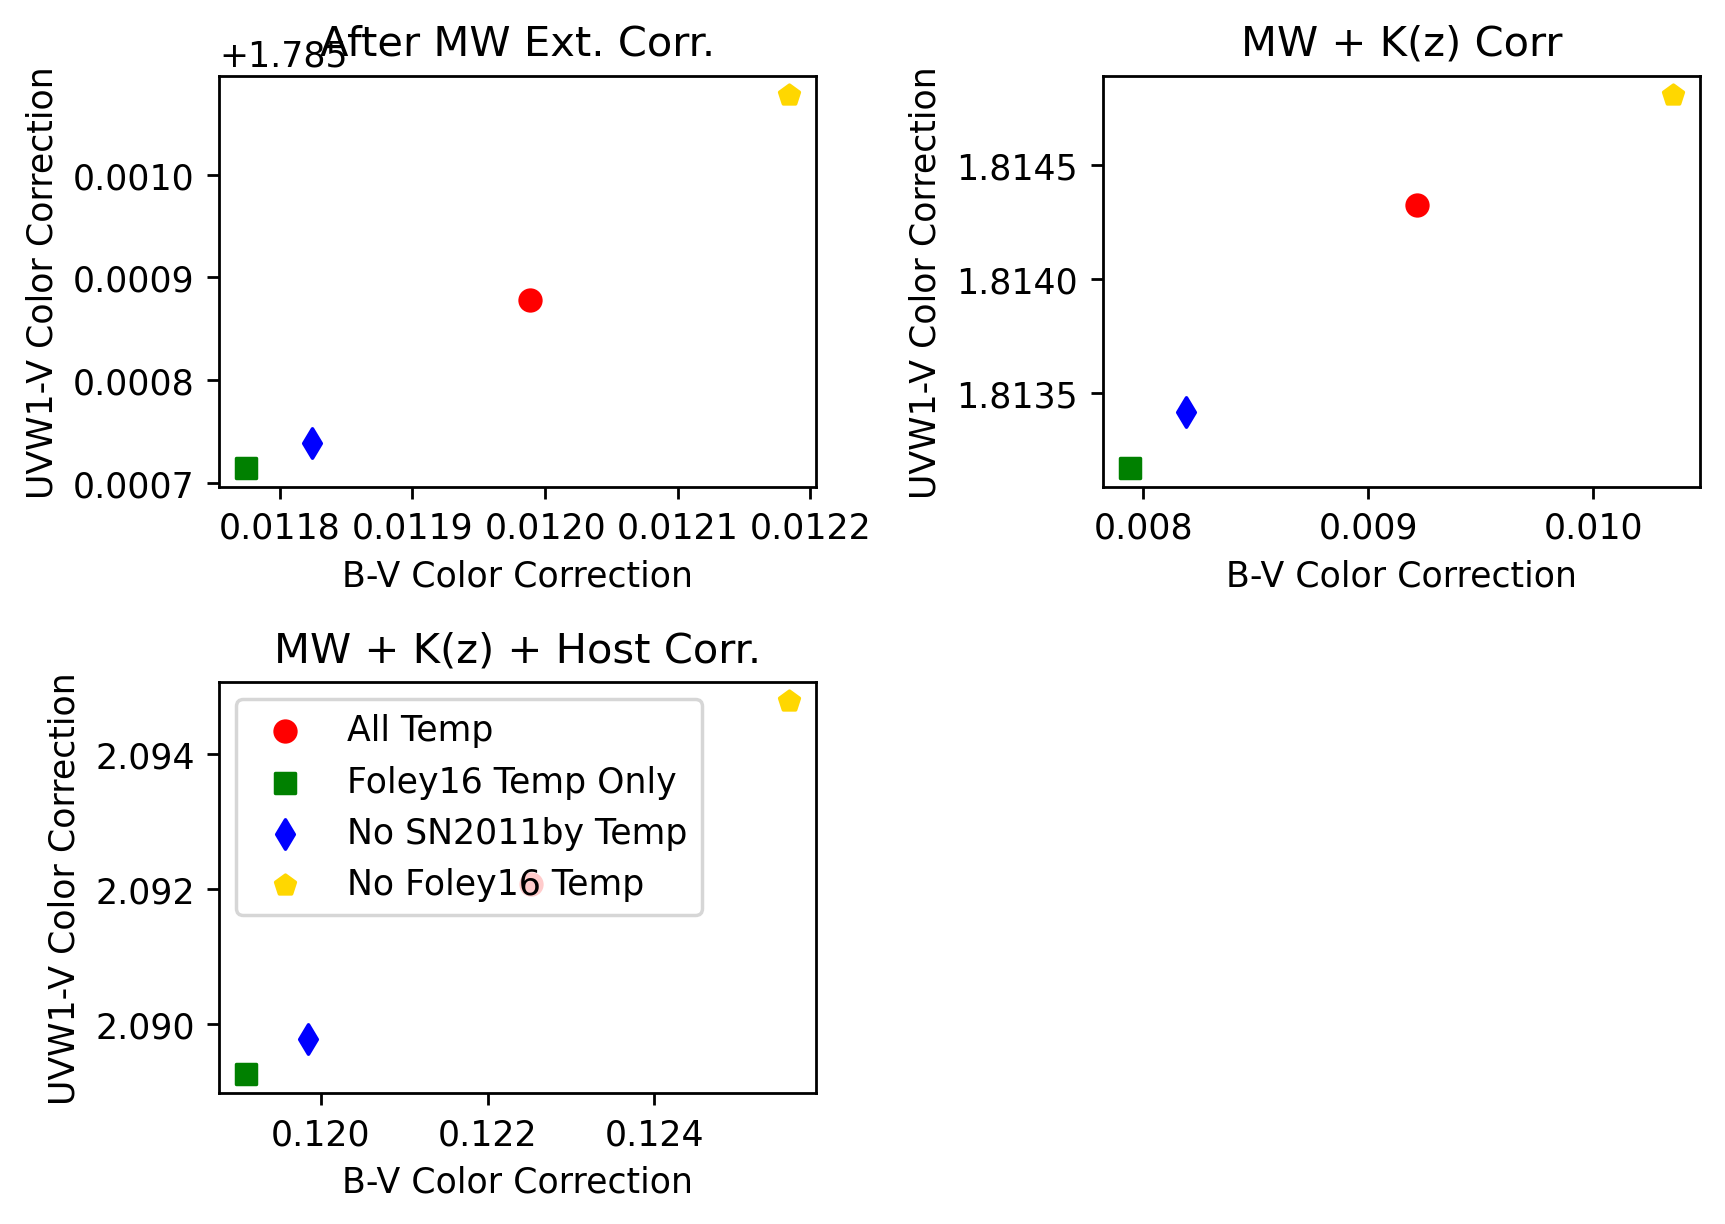

In [75]:
dog_all = pd.read_csv('outputs/SN2011by/output_all2.csv')
dog_foley = pd.read_csv('outputs/SN2011by/output_foley2.csv')
dog_noby = pd.read_csv('outputs/SN2011by/output_noby2.csv')
dog_otemp = pd.read_csv('outputs/SN2011by/output_obstemp2.csv')
targ = 'SN2011by'
df = pd.read_csv('SNPY_Sample_Decline_color2.csv')
tp = df.loc[(df.sname == targ)]
tp = tp.reset_index(drop=True)



In [122]:
rng = np.random.default_rng()

sample1 = stats.laplace.rvs(size=105, random_state=rng)
sample2 = stats.laplace.rvs(size=95, random_state=rng)
stats.ks_2samp(sample1, sample2)

Ks_2sampResult(statistic=0.09273182957393483, pvalue=0.7385636209705148)